In [1]:
utf8::utf8_print('\U0001f6a7 work in progress \U0001f6a7')

[1] "🚧​ work in progress 🚧​"


# click_annotvcf annotations analysis

Created: **27/08/18**  
Last modified: **30/08/18**

**Goal:** This notebook studies the annotations added with click_annotvcf, see [/data/annotate_with_click_annotvcf](https://github.com/ElsaB/impact-annotator/tree/master/data/annotate_with_click_annotvcf).  
This notebook is divided in !! parts:
* **1. Get click_annotvcf annotations**:  
* **2. IMPACT annotations vs VAGrENT annotations vs VEP annotations**:
* **4. Other VEP annotations**

**Refs:**
* [data/annotate_with_click_annotvcf](
https://github.com/ElsaB/impact-annotator/tree/master/data/annotate_with_click_annotvcf)

In [185]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

In [3]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, annotations = TRUE)

## Get click_annotvcf annotations

Get the features from `click_annotvcf_IMPACT_mutations_180508.txt` (impact annotated by the click_annotvcf pipeline).

### Get the raw data

In [4]:
impact_annotated <- read.table("../../../data/annotate_with_click_annotvcf/click_annotvcf_IMPACT_mutations_180508.txt",
                   sep = "\t", stringsAsFactors = FALSE, header = TRUE, comment = "#")

In [5]:
ncol(impact_annotated)
nrow(impact_annotated)
head(impact_annotated)

[1] 157

[1] 406770

ID_VARIANT    TARGET_NAME REFERENCE_NAME CHR START   END     REF ALT
1 1_2487766_T_C NA          NA             1   2487766 2487766 T   C  
2 1_2487954_G_A NA          NA             1   2487954 2487954 G   A  
3 1_2487984_C_A NA          NA             1   2487984 2487984 C   A  
4 1_2487998_C_G NA          NA             1   2487998 2487998 C   G  
5 1_2487998_C_T NA          NA             1   2487998 2487998 C   T  
6 1_2488032_A_G NA          NA             1   2488032 2488032 A   G  
  CONTEXT_5 CHANGE CONTEXT_3 QUAL CALLED_BY PASSED_BY NUMBER_OF_CALLERS
1 TGGAA     C      GGTGC     NA   NA        NA        0                
2 GCTCG     A      GTTCT     NA   NA        NA        0                
3 CGAGG     A      GGATT     NA   NA        NA        0                
4 TTTCT     G      TTTCT     NA   NA        NA        0                
5 TTTCT     T      TTTCT     NA   NA        NA        0                
6 CAGCA     G      TGGCG     NA   NA        NA        0                
  FLAGS_ALL TARGET_VAF_MEAN TARGET_VAF_STD REFERENCE_VAF_MEAN REFERENCE_VAF_STD
1 PASS      NA              NA             NA                 NA               
2 PASS      NA              NA             NA                 NA               
3 PASS      NA              NA             NA                 NA               
4 PASS      NA              NA             NA                 NA               
5 PASS      NA              NA             NA                 NA               
6 PASS      NA              NA             NA                 NA               
  mutect_TARGET_VAF mutect_TARGET_DEPTH mutect_REFERENCE_VAF
1 NA                NA                  NA                  
2 NA                NA                  NA                  
3 NA                NA                  NA                  
4 NA                NA                  NA                  
5 NA                NA                  NA                  
6 NA                NA                  NA                  
  mutect_REFERENCE_DEPTH mutect_DIRPROP mutect_READS_FORWARD
1 NA                     NA             NA                  
2 NA                     NA             NA                  
3 NA                     NA             NA                  
4 NA                     NA             NA                  
5 NA                     NA             NA                  
6 NA                     NA             NA                  
  mutect_READS_REVERSE strelka_TARGET_VAF strelka_TARGET_DEPTH
1 NA                   NA                 NA                  
2 NA                   NA                 NA                  
3 NA                   NA                 NA                  
4 NA                   NA                 NA                  
5 NA                   NA                 NA                  
6 NA                   NA                 NA                  
  strelka_REFERENCE_VAF strelka_REFERENCE_DEPTH caveman_TARGET_VAF
1 NA                    NA                      NA                
2 NA                    NA                      NA                
3 NA                    NA                      NA                
4 NA                    NA                      NA                
5 NA                    NA                      NA                
6 NA                    NA                      NA                
  caveman_TARGET_DEPTH caveman_REFERENCE_VAF caveman_REFERENCE_DEPTH
1 NA                   NA                    NA                     
2 NA                   NA                    NA                     
3 NA                   NA                    NA                     
4 NA                   NA                    NA                     
5 NA                   NA                    NA                     
6 NA                   NA                    NA                     
  caveman_DIRPROP caveman_READS_FORWARD caveman_READS_REVERSE CAVEMAN_DS
1 NA              NA                    NA                    NA        
2 NA              NA                    NA      

In [6]:
id_colnames  <- c("ID_VARIANT", "CHR", "START", "END", "REF", "ALT")
vag_colnames <- c("VAG_VT", "VAG_GENE", "VAG_cDNA_CHANGE", "VAG_PROTEIN_CHANGE", "VAG_EFFECT")
vep_colnames <- c("VEP_Consequence", "VEP_BIOTYPE", "VEP_SYMBOL", "VEP_EXON", "VEP_INTRON", "VEP_HGVSc",
                  "VEP_HGVSp", "VEP_Amino_acids", "VEP_VARIANT_CLASS", "VEP_SIFT", "VEP_PolyPhen")
    
vep_gnomad_colnames <- c("VEP_gnomAD_AF", "VEP_MAX_AF", "VEP_MAX_AF_POPS")
vep_cosmic_colnames <- c("VEP_COSMIC", "VEP_COSMIC_CDS", "VEP_COSMIC_AA", "VEP_COSMIC_CNT")

colnames_to_keep <- c(id_colnames, vag_colnames, vep_colnames, vep_gnomad_colnames, vep_cosmic_colnames)

impact_annotated <- impact_annotated[, colnames_to_keep]

### Create keys to join the two dataframes and extract the features

We are going to identify each mutation with a key in both dataframes, allowing us to link each mutation from `impact` to its corresponding mutation in `impact_annotated`. The keys will be: 
* `mut_key` for `impact`
* `CHR`\_`START`\_`REF`\_`ALT` for `impact_annotated`, however because the file was annotated from `impact` converted to `.vcf` format, there's a correction to be made for `INS` and `DEL` (ex: for insertions the syntax is `-/A` for `impact` vs `T/TA` for `impact_annotated`).

In [7]:
get_join_key <- function(data) {
    
    # if insertion or deletion
    if (substr(data["REF"], 1, 1) == substr(data["ALT"], 1, 1) &
        (nchar(data["REF"]) == 1 | nchar(data["ALT"]) == 1)) {
        
        # remove leading base
        data["REF"] = substr(data["REF"], 2, nchar(data["REF"]))
        data["ALT"] = substr(data["ALT"], 2, nchar(data["ALT"]))
        
        # different correction for insertion vs deletion
        if (nchar(data["REF"]) == 0)
            data["REF"] = '-'
        else {
            data["ALT"] = '-'
            data["START"] = as.numeric(data["START"]) + 1
        }
    }

    return (gsub(' ', '', (paste(data["CHR"], data["START"], data["REF"], data["ALT"], sep = "_"))))
}

impact_annotated$join_key <- apply(impact_annotated, 1, get_join_key)
head(impact_annotated$join_key)

[1] "1_2487766_T_C" "1_2487954_G_A" "1_2487984_C_A" "1_2487998_C_G"
[5] "1_2487998_C_T" "1_2488032_A_G"

**Verification 1** Make sure every impact `mut_key` has an analoguous `join_key` in `impact_annotated`:

Somehow some insertions and deletions don't have the same format, but have the original `.vcf` format.

In [8]:
is_unmatched <- which(! impact$mut_key %in% impact_annotated$join_key)
table(impact$Variant_Type[is_unmatched]) # only DEL and INS
head(impact[is_unmatched, c("Variant_Type", "Reference_Allele", "Tumor_Seq_Allele2")]) # which have the .vcf format


DEL INS 
 78   9 

Variant_Type Reference_Allele                                           
8669  DEL          GAGCAGCAGC                                                 
22259 DEL          GTGATAGCACTGAGAGCACTGCGAACAGGCAAGGAGGTGGCCCTCTGCCCCCCGGCCAA
33515 DEL          AACCCATGTATGAAGT                                           
36147 DEL          GCCTCCGGCCCCGAAGAGCCCCT                                    
40602 DEL          ACCTGCCAGAG                                                
41558 DEL          AT                                                         
      Tumor_Seq_Allele2
8669  G                
22259 G                
33515 A                
36147 G                
40602 A                
41558 A

In [9]:
head(impact$cDNA_change[is_unmatched], 10)

[1] "c.186_196delinsCT"                    
 [2] "c.4157_4216delinsCA"                  
 [3] "c.1648_1664delinsCA"                  
 [4] "c.491_514delinsCT"                    
 [5] "c.194-9_196delinsTG"                  
 [6] "c.320_322delinsTA"                    
 [7] "c.2033_2035delinsCT"                  
 [8] "c.6835_6836delinsGTA"                 
 [9] "c.1726_1727delinsATGATCACAAATGGGAGTGA"
[10] "c.1726_1727delinsATGATCACAAATGGGAGTGA"

In [10]:
nrow(impact)

[1] 248293

In [11]:
is_matched <- which(impact$mut_key %in% impact_annotated$join_key)
head(impact$cDNA_change[is_matched & impact$Variant_Type == "INS"], 10)

Warning message in is_matched & impact$Variant_Type == "INS":
“longer object length is not a multiple of shorter object length”

[1] "c.2538dupT"          "c.875dupA"           "c.906_907insC"      
 [4] "c.903_906delinsACAC" "c.1344dupA"          "c.620dupA"          
 [7] "c.2206dupA"          "c.2864dupC"          "c.1003dupT"         
[10] "c.1364dupA"

In [12]:
# not sure what to do, remove them from now

impact <- impact[is_matched,]

!!!

***

***

***  

For these mutations we will use `ID_VARIANT` as a `join_key` (they were still annotated as no change was made to them during the conversion to `.vcf`). We won't affect any other mutation by modyfing these `join_key`.

In [13]:
# are the corrected mut_key elsewhere in the dataset?

correct_ref_and_alt <- function(data, correct_del_start_position) {
    
    data$Reference_Allele <- substr(data$Reference_Allele, 2, nchar(data$Reference_Allele))
    data$Tumor_Seq_Allele2 <- substr(data$Tumor_Seq_Allele2, 2, nchar(data$Tumor_Seq_Allele2))
    
    data$Reference_Allele[data$Variant_Type == "INS"] <- '-'
    data$Tumor_Seq_Allele2[data$Variant_Type == "DEL"] <- '-'
    
    if (correct_del_start_position)
        data$Start_Position <- as.numeric(data$Start_Position) + 1
    
    return (data)
}

head(correct_ref_and_alt(impact[is_unmatched,], TRUE)[,c("Variant_Type", "Reference_Allele", "Tumor_Seq_Allele2")])
table(correct_ref_and_alt(impact[is_unmatched,], TRUE)$mut_key %in% impact$mut_key[! is_unmatched])
table(correct_ref_and_alt(impact[is_unmatched,], FALSE)$mut_key %in% impact$mut_key[! is_unmatched])

Variant_Type Reference_Allele Tumor_Seq_Allele2
8670  SNP                                            
22261 SNP                                            
33518 SNP                                            
36151 SNP                                            
40607 SNP                                            
41564 SNP


FALSE 
   87 


FALSE 
   87 

In [14]:
# corresponding to impact_annotated$ID_VARIANT
table(unique(impact$mut_key[is_unmatched]) %in% impact_annotated$ID_VARIANT)


FALSE  TRUE 
   16    71 

In [15]:
table(impact$mut_key[is_unmatched] %in% impact$mut_key[! is_unmatched])


FALSE 
   87 

However, some mutations having the same key but in the not `.vcf` format (eg `AGCAGCAGC_-` instead of `GAGCAGCAGC_G`) would be lost if we would just replace the `impact_annotated` `join_key` for these mutations. Thus, we will create new rows having the good `join_key` especially for these mutations:

In [16]:
table(unique(impact$mut_key[is_unmatched]) %in% impact_annotated$ID_VARIANT)
table(impact_annotated$ID_VARIANT %in% impact$mut_key[is_unmatched])


FALSE  TRUE 
   16    71 


 FALSE   TRUE 
406699     71 

In [17]:
to_change <- which(impact_annotated$ID_VARIANT %in% impact$mut_key[is_unmatched])

#impact_annotated$join_key[to_change] <- impact_annotated$ID_VARIANT[to_change]

In [18]:
correct_ref_and_alt <- function(data) {
    
    data$Reference_Allele = substr(data$Reference_Allele, 2, nchar(data$Reference_Allele))
    data$Tumor_Seq_Allele2 = substr(data$Tumor_Seq_Allele2, 2, nchar(data$Tumor_Seq_Allele2))
    
    data$Reference_Allele[data$Variant_Type == "INS"] <- '-'
    data$Tumor_Seq_Allele2[data$Variant_Type == "DEL"] <- '-'
    
    #data["START"] = as.numeric(data["START"]) + 1
    
    return (data)
}

#impact2[is_unmatched,] <- correct_ref_and_alt(impact2[is_unmatched,])

#is_unmatched <- which(! impact2$mut_key %in% impact$mut_key)
#nrow(impact2[is_unmatched,])
#head(impact2[is_unmatched, c("Variant_Type", "Reference_Allele", "Tumor_Seq_Allele2")], 100)

In [19]:
is_unmatched <- which(! impact$mut_key %in% impact_annotated$join_key)
table(impact$Variant_Type[is_unmatched]) # only DEL and INS
head(impact[is_unmatched, c("Variant_Type", "Reference_Allele", "Tumor_Seq_Allele2")]) # which have the .vcf format

< table of extent 0 >

Variant_Type Reference_Allele Tumor_Seq_Allele2

In [20]:
head(impact$cDNA_change[impact$Variant_Type == "INS"])
nrow(impact)

[1] "c.2538dupT"          "c.875dupA"           "c.906_907insC"      
[4] "c.903_906delinsACAC" "c.1344dupA"          "c.620dupA"

[1] 248206

**Verification 2** The features are unique for each `join_key`:

In [21]:
impact_annotated <- unique(impact_annotated)

In [22]:
nrow(impact_annotated %>% group_by(join_key) %>% filter(n() > 1))

[1] 0

In [23]:
colnames_to_keep <- c(vag_colnames, vep_colnames, vep_gnomad_colnames, vep_cosmic_colnames)

In [24]:
impact[, colnames_to_keep] <- left_join(impact, impact_annotated,
                                        by = c("mut_key" = "join_key"))[, c(vag_colnames,
                                                                            vep_colnames,
                                                                            vep_gnomad_colnames,
                                                                            vep_cosmic_colnames)]

In [25]:
head(impact)

Hugo_Symbol Chromosome Start_Position End_Position Consequence      
1 TP53        17           7577515        7577515    nonsynonymous_SNV
2 ARID1A      1           27101572       27101572    synonymous_SNV   
3 PTPRS       19           5244030        5244030    synonymous_SNV   
4 PIK3R3      1           46521514       46521514    nonsynonymous_SNV
5 ATR         3          142178126      142178126    nonsynonymous_SNV
6 PDGFRA      4           55139732       55139732    nonsynonymous_SNV
  Variant_Type Reference_Allele Tumor_Seq_Allele2 Tumor_Sample_Barcode
1 SNP          T                G                 P-0000012-T02-IM3   
2 SNP          C                G                 P-0000012-T02-IM3   
3 SNP          C                G                 P-0000012-T02-IM3   
4 SNP          G                C                 P-0000012-T03-IM3   
5 SNP          C                A                 P-0000012-T03-IM3   
6 SNP          T                A                 P-0000012-T03-IM3   
  cDNA_change HGVSp_Short t_depth t_vaf   t_alt_count n_depth n_vaf  
1 c.766A>C    p.T256P     227     0.50220 114          569    0.00000
2 c.4854C>G   p.P1618P    281     0.07829  22          879    0.00000
3 c.1452G>C   p.L484L     299     0.37793 113          730    0.00274
4 c.894C>G    p.I298M     733     0.17599 129         1243    0.00000
5 c.7292G>T   p.R2431M    482     0.17427  84          581    0.00172
6 c.1393T>A   p.L465M     570     0.20351 116          811    0.00000
  n_alt_count t_ref_plus_count t_ref_neg_count t_alt_plus_count t_alt_neg_count
1 0            59               54             58               56             
2 0           126              129             11               11             
3 2            97               87             61               52             
4 0           288              316             61               68             
5 1           221              177             46               38             
6 0           252              202             66               50             
  confidence_class sample_coverage mut_key        
1 AUTO_OK          344             17_7577515_T_G 
2 UNKNOWN          344             1_27101572_C_G 
3 UNKNOWN          344             19_5244030_C_G 
4 AUTO_OK          428             1_46521514_G_C 
5 AUTO_OK          428             3_142178126_C_A
6 AUTO_OK          428             4_55139732_T_A 
  sample_mut_key                    frequency_in_normals Kaviar_AF cosmic_count
1 P-0000012-T02-IM3_17_7577515_T_G  0                    0.0e+00   1           
2 P-0000012-T02-IM3_1_27101572_C_G  0                    0.0e+00   0           
3 P-0000012-T02-IM3_19_5244030_C_G  0                    0.0e+00   0           
4 P-0000012-T03-IM3_1_46521514_G_C  0                    0.0e+00   0           
5 P-0000012-T03-IM3_3_142178126_C_A 0                    6.5e-06   0           
6 P-0000012-T03-IM3_4_55139732_T_A  0                    0.0e+00   0           
  VAG_VT VAG_GENE VAG_cDNA_CHANGE VAG_PROTEIN_CHANGE VAG_EFFECT          
1 Sub    TP53     c.766A>C        p.T256P            non_synonymous_codon
2 Sub    ARID1A   c.4854C>G       p.P1618P           synonymous_codon    
3 Sub    PTPRS    c.1452G>C       p.L484L            synonymous_codon    
4 Sub    PIK3R3   c.1032C>G       p.I344M            non_synonymous_codon
5 Sub    ATR      c.7292G>T       p.R2431M           non_synonymous_codon
6 Sub    PDGFRA   c.1393T>A       p.L465M            non_synonymous_codon
  VEP_Consequence    VEP_BIOTYPE    VEP_SYMBOL VEP_EXON VEP_INTRON
1 missense_variant   protein_coding TP53       7|11     NA        
2 synonymous_variant protein_coding ARID1A     18|20    NA        
3 synonymous_variant protein_coding PTPRS      11|38    NA        
4 missense_variant   protein_coding PIK3R3     7|10     NA        
5 missense_variant   protein_coding ATR        43|47    NA        
6 missense_variant   protein_coding PDGFRA     10|23    NA        
  VEP_HGVSc                   VEP_HGVSp               

In [26]:
impact2 <- impact

In [110]:
nrow(impact)
impact <- impact2

[1] 248206

### Deal with `NA` values

!!!

In [111]:
count_na <- function(data) {
    return (sum(is.na(data)))
}

In [112]:
get_na <- function(data, feature_name) {
    return (data[is.na(data[,feature_name]),])
}

In [113]:
replace_na <- function(data, feature_name, replace_value){
    data[is.na(data[,feature_name]), feature_name] <- replace_value
    
    return (data)
}

#### VAGrENT

In [114]:
print(vag_colnames)

[1] "VAG_VT"             "VAG_GENE"           "VAG_cDNA_CHANGE"   
[4] "VAG_PROTEIN_CHANGE" "VAG_EFFECT"        


In [115]:
count_na(impact$VAG_VT)

[1] 0

158 mutations unknown by VAGrENT:

In [116]:
count_na(impact$VAG_GENE)
count_na(impact$VAG_EFFECT)

# the same mutations
nrow(impact[is.na(impact$VAG_GENE) & is.na(impact$VAG_EFFECT),]) == 158

[1] 158

[1] 158

[1] TRUE

[1] "Number of different genes:  97"


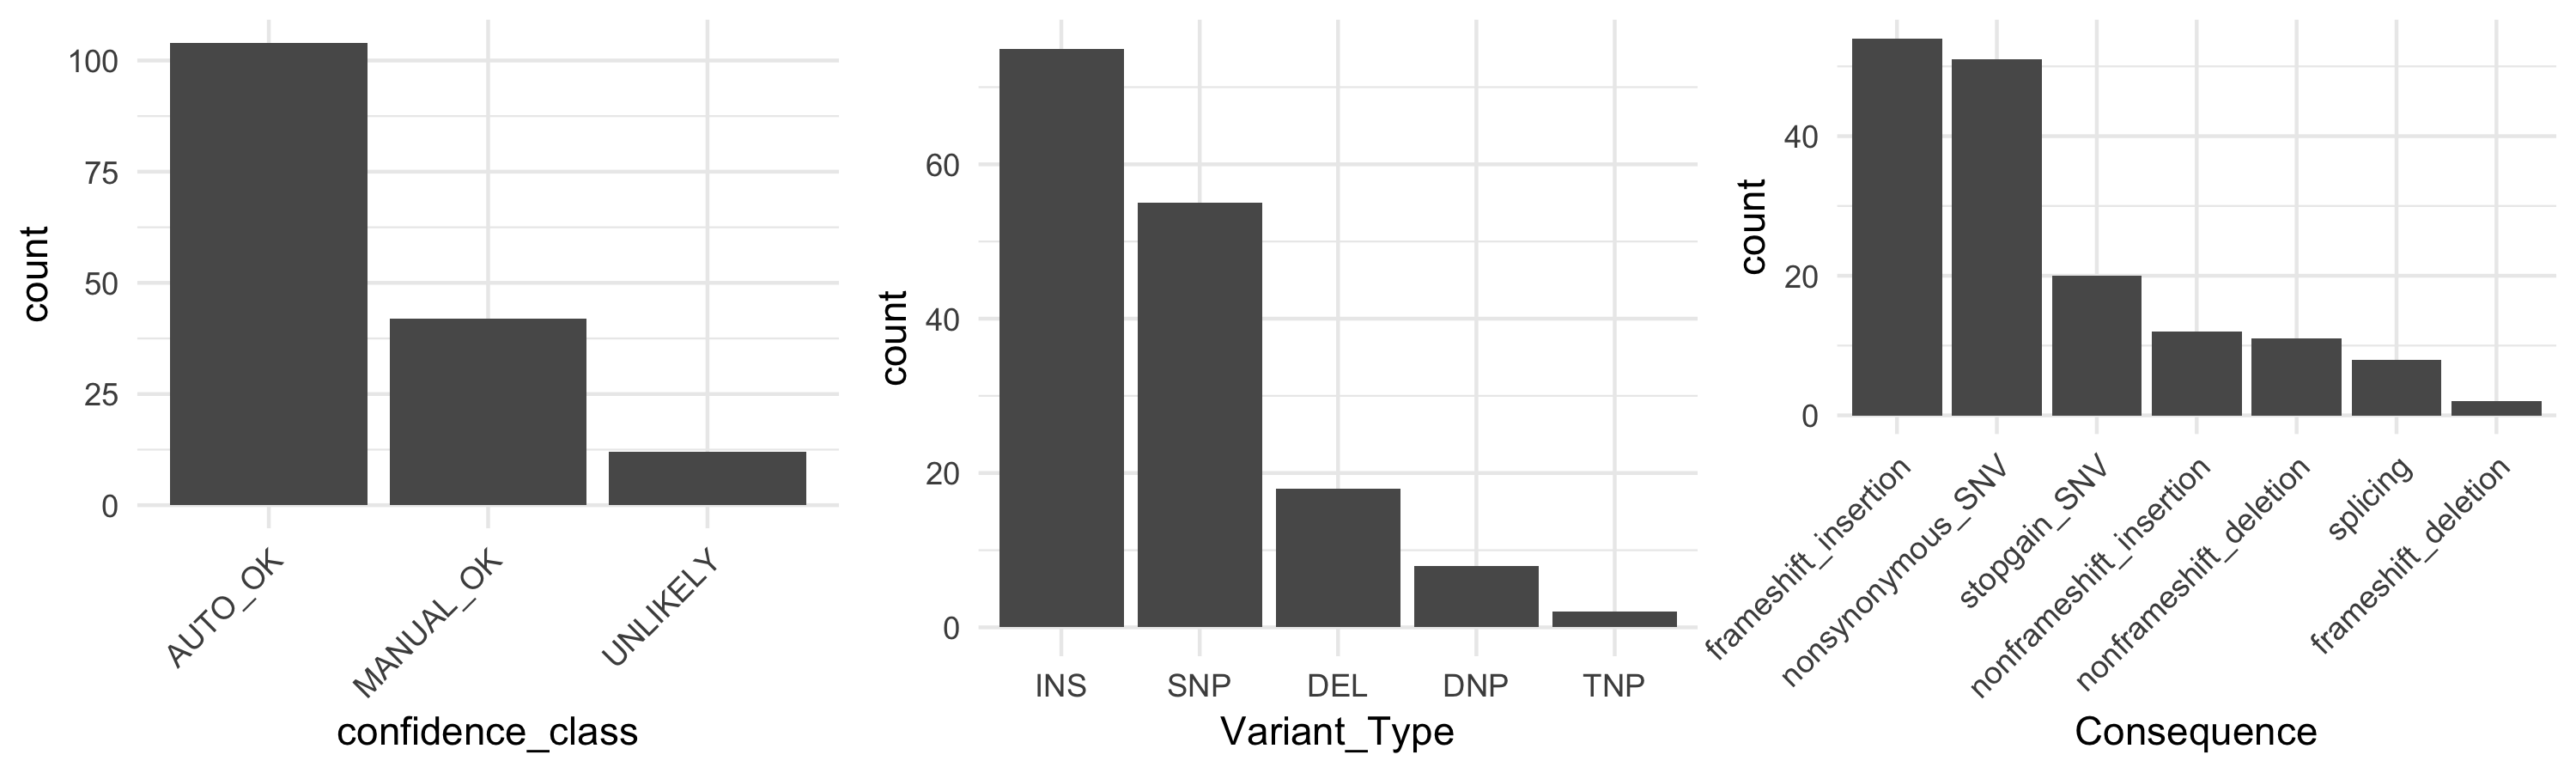

In [117]:
get_possible_correlations(get_na(impact, "VAG_GENE"))

[1] 515

[1] 515

[1] TRUE

[1] "Number of different genes:  130"


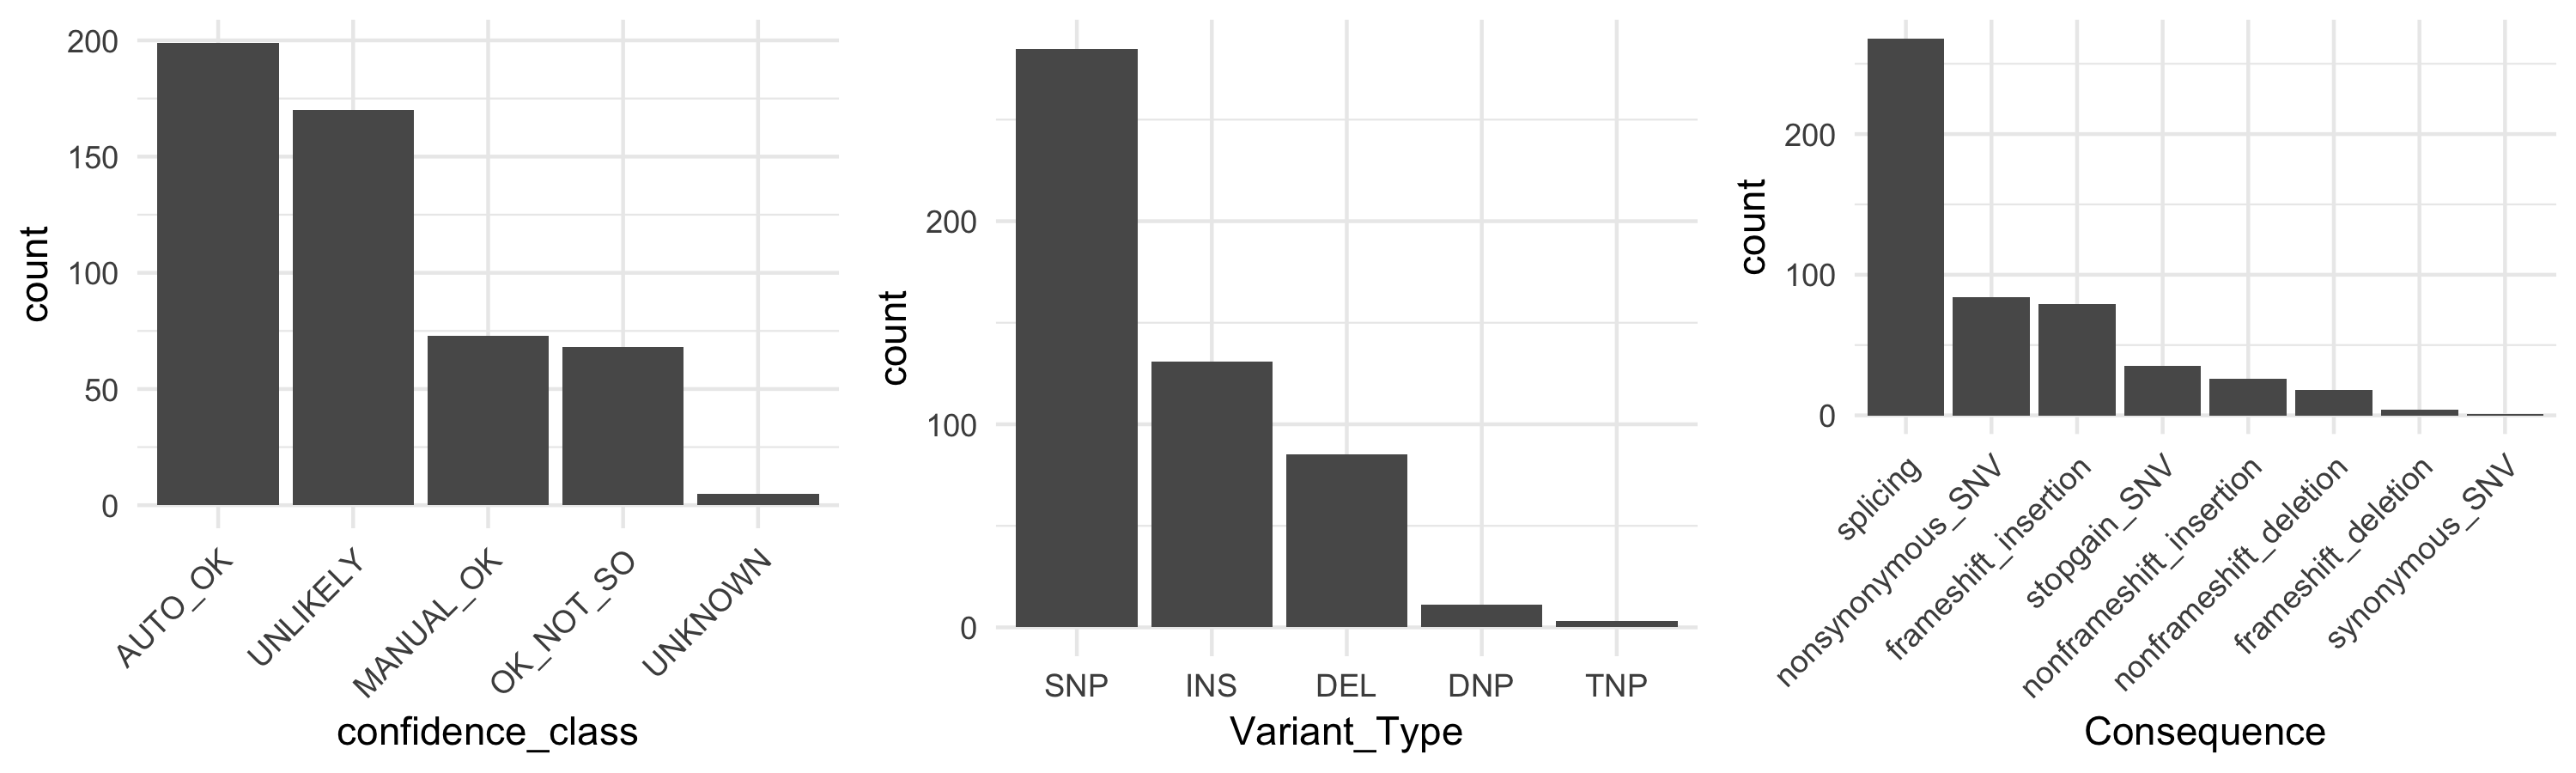

In [118]:
count_na(impact$VAG_cDNA_CHANGE)
count_na(impact$VAG_PROTEIN_CHANGE)

# the same mutations
nrow(impact[is.na(impact$VAG_cDNA_CHANGE) & is.na(impact$VAG_PROTEIN_CHANGE),]) == 515
get_possible_correlations(get_na(impact, "VAG_cDNA_CHANGE"))

The preceding 158 are included in these one.

In [119]:
table(impact$mut_key[is.na(impact$VAG_GENE)] %in% impact$mut_key[is.na(impact$VAG_cDNA_CHANGE)])


TRUE 
 158 

In [120]:
impact <- replace_na(impact, "VAG_GENE"          , "unknown")
impact <- replace_na(impact, "VAG_EFFECT"        , "unknown")
impact <- replace_na(impact, "VAG_cDNA_CHANGE"   , "unknown")
impact <- replace_na(impact, "VAG_PROTEIN_CHANGE", "unknown")

#### VEP

In [121]:
print(vep_colnames)

 [1] "VEP_Consequence"   "VEP_BIOTYPE"       "VEP_SYMBOL"       
 [4] "VEP_EXON"          "VEP_INTRON"        "VEP_HGVSc"        
 [7] "VEP_HGVSp"         "VEP_Amino_acids"   "VEP_VARIANT_CLASS"
[10] "VEP_SIFT"          "VEP_PolyPhen"     


In [122]:
count_na(impact$VEP_Consequence)
count_na(impact$VEP_VARIANT_CLASS)

[1] 0

[1] 0

In [123]:
count_na(impact$VEP_BIOTYPE)
count_na(impact$VEP_SYMBOL)
table(impact$VEP_Consequence[is.na(impact$VEP_SYMBOL)])

[1] 49

[1] 49


intergenic_variant 
                49 

In [124]:
count_na(impact$VEP_HGVSc)
get_table(impact$VEP_Consequence[is.na(impact$VEP_HGVSc)])

[1] 71

values                                                                            
1 intergenic_variant                                                                
2 downstream_gene_variant                                                           
3 upstream_gene_variant                                                             
4 coding_sequence_variant&5_prime_UTR_variant                                       
5 stop_lost&3_prime_UTR_variant                                                     
6 splice_donor_variant&coding_sequence_variant&5_prime_UTR_variant&intron_variant   
7 splice_donor_variant&5_prime_UTR_variant&intron_variant                           
8 splice_acceptor_variant&coding_sequence_variant&3_prime_UTR_variant&intron_variant
9 -- total --                                                                       
  count freq 
1 49    69%  
2 10    14.1%
3  6    8.5% 
4  2    2.8% 
5  1    1.4% 
6  1    1.4% 
7  1    1.4% 
8  1    1.4% 
9 71    100%

In [125]:
count_na(impact$VEP_HGVSp)
count_na(impact$VEP_Amino_acids)

[1] 8811

[1] 8794

In [126]:
impact <- replace_na(impact, "VEP_BIOTYPE"    , "unknown")
impact <- replace_na(impact, "VEP_SYMBOL"     , "unknown")
impact <- replace_na(impact, "VEP_HGVSc"      , "unknown")
impact <- replace_na(impact, "VEP_HGVSp"      , "unknown")
impact <- replace_na(impact, "VEP_Amino_acids", "unknown")

In [127]:
count_na(impact$VEP_EXON)
count_na(impact$VEP_INTRON)

nrow(impact[is.na(impact$VEP_EXON) & is.na(impact$VEP_INTRON),])

[1] 7446

[1] 239590

[1] 107

In [128]:
count_na(impact$VEP_SIFT)
count_na(impact$VEP_PolyPhen)

[1] 106989

[1] 105935

In [204]:
impact <- replace_na(impact, "VEP_SIFT", "unknown")
impact <- replace_na(impact, "VEP_PolyPhen", "unknown")

ERROR: Error in `[.data.frame`(data, , feature_name): undefined columns selected


#### VEP gnomAD

In [130]:
print(vep_gnomad_colnames)

[1] "VEP_gnomAD_AF"   "VEP_MAX_AF"      "VEP_MAX_AF_POPS"


In [131]:
count_na(impact$VEP_gnomAD_AF)
count_na(impact$VEP_MAX_AF)
count_na(impact$VEP_MAX_AF_POPS)

[1] 192164

[1] 196853

[1] 191563

`NA` values might correspond to not found, we replace them by a null allele frequency.

In [132]:
impact <- replace_na(impact, "VEP_gnomAD_AF"  , 0.0)
impact <- replace_na(impact, "VEP_MAX_AF"     , 0.0)
impact <- replace_na(impact, "VEP_MAX_AF_POPS", "unknown")

#### VEP COSMIC

In [133]:
print(vep_cosmic_colnames)

[1] "VEP_COSMIC"     "VEP_COSMIC_CDS" "VEP_COSMIC_AA"  "VEP_COSMIC_CNT"


In [134]:
count_na(impact$VEP_COSMIC)
count_na(impact$VEP_COSMIC_CDS)
count_na(impact$VEP_COSMIC_AA)
count_na(impact$VEP_COSMIC_CNT)

[1] 175503

[1] 175548

[1] 175548

[1] 175548

`NA` values might correspond to not found, we replace them by a null cosmic count.

In [135]:
impact <- replace_na(impact, "VEP_COSMIC"    , "unknown")
impact <- replace_na(impact, "VEP_COSMIC_CDS", "unknown")
impact <- replace_na(impact, "VEP_COSMIC_AA" , "unknown")
impact <- replace_na(impact, "VEP_COSMIC_CNT", 0)

### Process raw features

#### `VEP_HGVSc`

In [136]:
dd <- head(impact$VEP_HGVSc, 10)
dd <- data.frame(dd, sapply(dd, function(x) strsplit(x, ':')[[1]][2]), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old                           new        
1  ENST00000269305.4:c.766A>C    c.766A>C   
2  ENST00000324856.7:c.4854C>G   c.4854C>G  
3  ENST00000357368.4:c.1452G>C   c.1452G>C  
4  ENST00000262741.5:c.894C>G    c.894C>G   
5  ENST00000350721.4:c.7292G>T   c.7292G>T  
6  ENST00000257290.5:c.1393T>A   c.1393T>A  
7  ENST00000281708.4:c.1237-1G>T c.1237-1G>T
8  ENST00000281708.4:c.181G>T    c.181G>T   
9  ENST00000264932.6:c.1444C>T   c.1444C>T  
10 ENST00000399503.3:c.904G>T    c.904G>T

In [137]:
impact$VEP_HGVSc <- sapply(impact$VEP_HGVSc, function(x) strsplit(x, ':')[[1]][2])

#### `VEP_HGVSp`

In [138]:
get_HGVSp_from_vep <- function(HGVSp_string) {
    
    if (HGVSp_string == "unknown")
        return ("unknown")
    
    HGVSp_string <- strsplit(HGVSp_string, ':')[[1]][2]
    
    protein_long_name <- c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Glu', 'Gln', 'Gly', 'His', 'Ile', 'Leu', 'Lys',
                           'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')
    protein_short_name <- c('A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K',
                            'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')
    
    for (name in protein_long_name)
        HGVSp_string <- gsub(name, protein_short_name[match(name, protein_long_name)], HGVSp_string)
    
    HGVSp_string <- gsub('Ter', '*', HGVSp_string)
    HGVSp_string <- gsub('%3D', '=', HGVSp_string)
    
    return (HGVSp_string)
}

In [139]:
dd <- head(impact$VEP_HGVSp, 10)
dd <- data.frame(dd, sapply(dd, get_HGVSp_from_vep), row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old                            new     
1  ENSP00000269305.4:p.Thr256Pro  p.T256P 
2  ENSP00000320485.7:p.Pro1618%3D p.P1618=
3  ENSP00000349932.4:p.Leu484%3D  p.L484= 
4  ENSP00000262741.5:p.Ile298Met  p.I298M 
5  ENSP00000343741.4:p.Arg2431Met p.R2431M
6  ENSP00000257290.5:p.Leu465Met  p.L465M 
7  unknown                        unknown 
8  ENSP00000281708.3:p.Gly61Ter   p.G61*  
9  ENSP00000264932.6:p.Pro482Ser  p.P482S 
10 ENSP00000382423.3:p.Glu302Ter  p.E302*

In [140]:
impact$VEP_HGVSp <- sapply(impact$VEP_HGVSp, get_HGVSp_from_vep)

#### `VEP_SIFT`

In [142]:
dd <- head(unique(impact$VEP_SIFT), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) strsplit(x, '\\(')[[1]][1]),
                 sapply(dd, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2]))),
                 row.names = NULL)
colnames(dd) <- c("old", "new1", "new2")
dd

old                            new1                       new2
1  deleterious(0)                 deleterious                0.00
2  unknown                        unknown                      NA
3  deleterious(0.01)              deleterious                0.01
4  tolerated_low_confidence(0.12) tolerated_low_confidence   0.12
5  tolerated(0.4)                 tolerated                  0.40
6  tolerated(0.17)                tolerated                  0.17
7  deleterious(0.02)              deleterious                0.02
8  deleterious_low_confidence(0)  deleterious_low_confidence 0.00
9  tolerated_low_confidence(0.1)  tolerated_low_confidence   0.10
10 tolerated(0.08)                tolerated                  0.08

In [143]:
impact$VEP_SIFT_class <- sapply(impact$VEP_SIFT, function(x) strsplit(x, '\\(')[[1]][1])
impact$VEP_SIFT_score <- sapply(impact$VEP_SIFT, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2])))
impact$VEP_SIFT <- NULL

#### `VEP_PolyPhen`

In [203]:
dd <- head(unique(impact$VEP_PolyPhen), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) strsplit(x, '\\(')[[1]][1]),
                 sapply(dd, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2]))),
                 row.names = NULL)
colnames(dd) <- c("old", "new1", "new2")
dd

old        new1    new2
NA  NA         NA      NA  
217 unknown(0) unknown  0

In [145]:
impact$VEP_PolyPhen_class <- sapply(impact$VEP_PolyPhen, function(x) strsplit(x, '\\(')[[1]][1])
impact$VEP_PolyPhen_score <- sapply(impact$VEP_PolyPhen, function(x) as.numeric(gsub(')', '', strsplit(x, '\\(')[[1]][2])))
impact$VEP_PolyPhen <- NULL

#### `VEP_COSMIC_CNT`

In [146]:
dd <- head(unique(impact$VEP_COSMIC_CNT), 10)
dd <- data.frame(dd,
                 sapply(dd, function(x) sum(as.integer(strsplit(x, '&')[[1]]))),
                 row.names = NULL)
colnames(dd) <- c("old", "new")
dd

old                     new 
1  1                          1
2  0                          0
3  1&1&1&1&1&1                6
4  1&1&1                      3
5  1&1                        2
6  53                        53
7  158                      158
8  19&21&14                  54
9  229&230&200&230&179&789 1857
10 42&170                   212

In [147]:
impact$VEP_COSMIC_CNT <- sapply(impact$VEP_COSMIC_CNT, function(x) sum(as.integer(strsplit(x, '&')[[1]])))

## IMPACT annotations vs VAGrENT annotations vs VEP annotations

!!! all

In [64]:
print(vag_colnames)
print(vep_colnames)

[1] "VAG_VT"             "VAG_GENE"           "VAG_cDNA_CHANGE"   
[4] "VAG_PROTEIN_CHANGE" "VAG_EFFECT"        
 [1] "VEP_Consequence"   "VEP_BIOTYPE"       "VEP_SYMBOL"       
 [4] "VEP_EXON"          "VEP_INTRON"        "VEP_HGVSc"        
 [7] "VEP_HGVSp"         "VEP_Amino_acids"   "VEP_VARIANT_CLASS"
[10] "VEP_SIFT"          "VEP_PolyPhen"     


### `Variant_Type` vs `VAG_VT` vs `VEP_VARIANT_CLASS`

     
      Complex    Del    Ins    Sub
  DEL     615  22734      0      0
  DNP    2872      0      0      0
  INS     132      0   7698      0
  SNP      86      0      0 213880
  TNP     189      0      0      0

     
      deletion  indel insertion    SNV substitution
  DEL    22315   1013         0      0           21
  DNP        0      0         0      0         2872
  INS        0    153      7653      0           24
  SNP        0      0         0 213880           86
  TNP        0      0         0      0          189

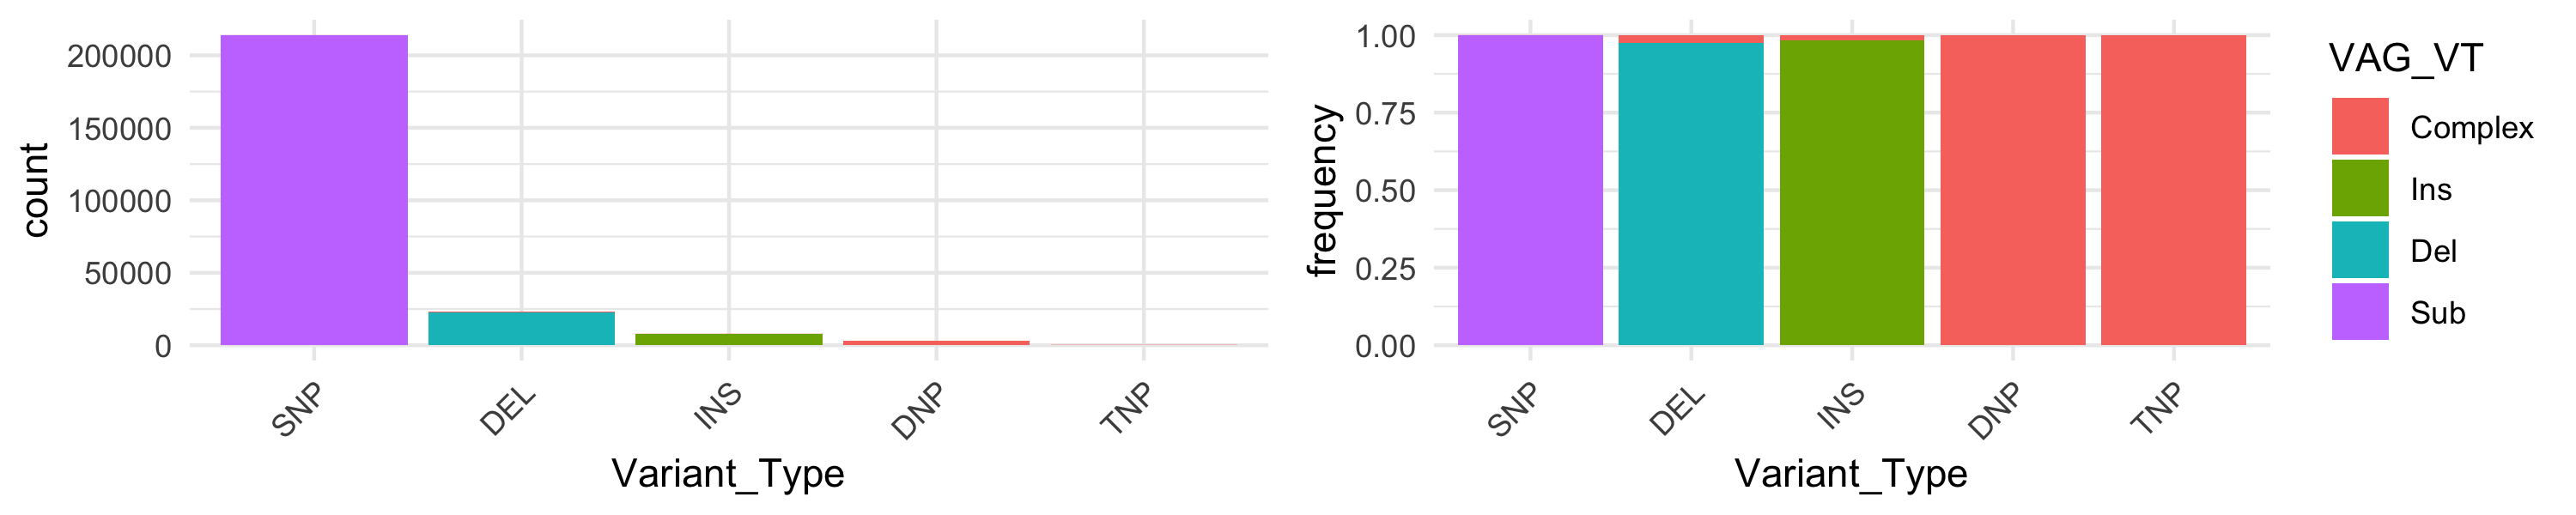

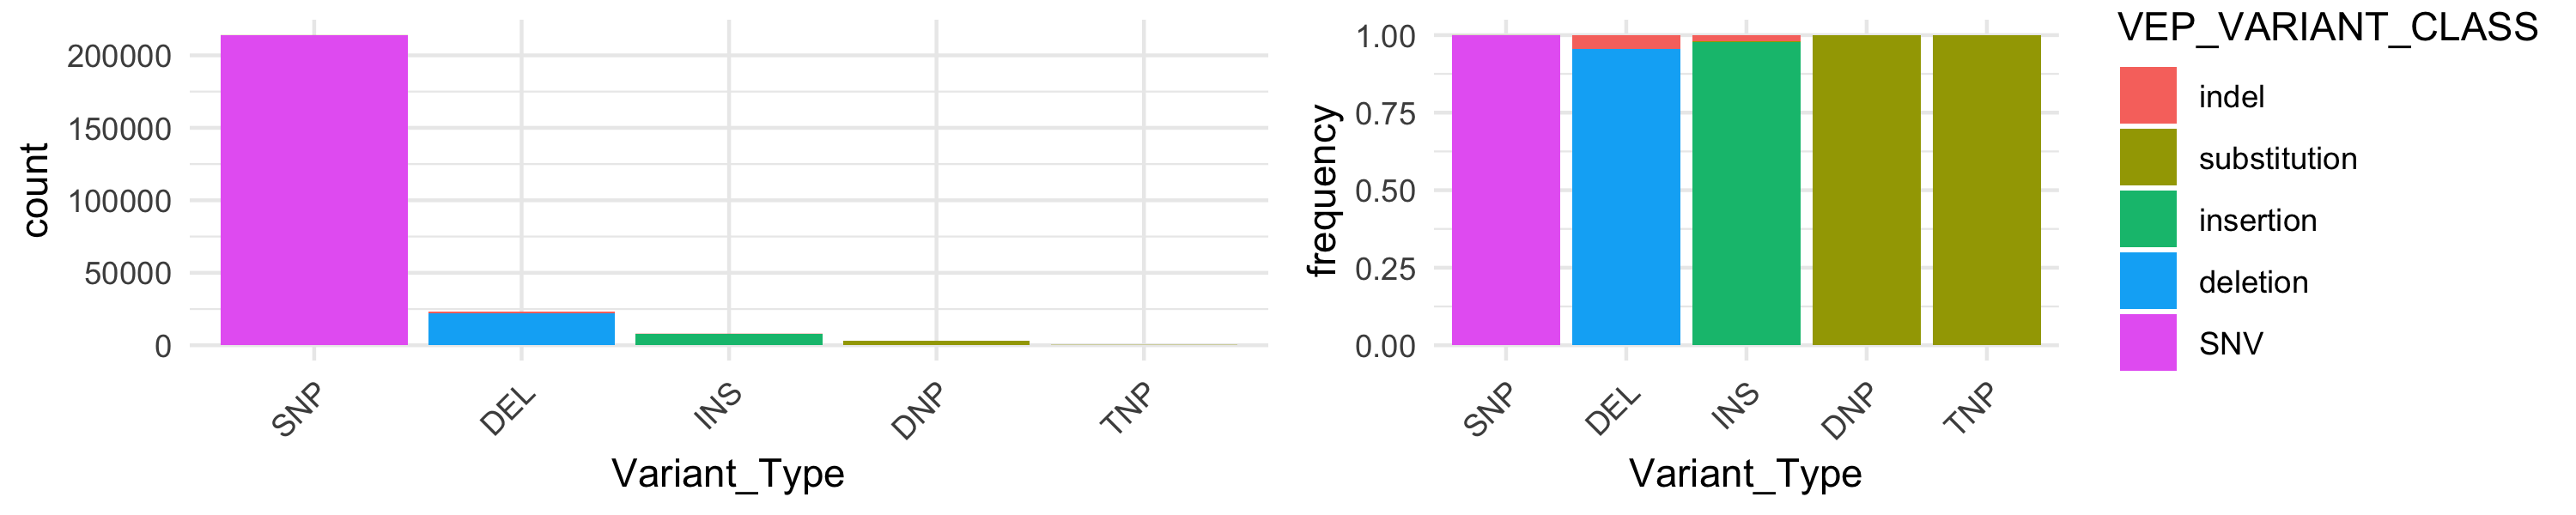

In [65]:
table(impact$Variant_Type, impact$VAG_VT)
table(impact$Variant_Type, impact$VEP_VARIANT_CLASS)

plot_contingency_table_as_histograms(impact, "Variant_Type", "VAG_VT", height = 2)
plot_contingency_table_as_histograms(impact, "Variant_Type", "VEP_VARIANT_CLASS", height = 2)

### `Consequence` vs `VAG_EFFECT` vs `VEP_Consequence`

!!!

In [66]:
get_table(impact$Consequence)
get_table(impact$VAG_EFFECT)
get_table(impact$VEP_Consequence)

values                  count  freq 
1 nonsynonymous_SNV       142688 57.5%
2 synonymous_SNV           50005 20.1%
3 stopgain_SNV             18765 7.6% 
4 frameshift_deletion      16679 6.7% 
5 splicing                  8452 3.4% 
6 frameshift_insertion      6417 2.6% 
7 nonframeshift_deletion    4282 1.7% 
8 nonframeshift_insertion    918 0.4% 
9 -- total --             248206 100%

values                                         count  freq 
1  non_synonymous_codon                           142069 57.2%
2  synonymous_codon                                50400 20.3%
3  frameshift_variant                              23849 9.6% 
4  stop_gained                                     17906 7.2% 
5  splice_site_variant                              5709 2.3% 
6  inframe_codon_loss                               3782 1.5% 
7  complex_change_in_transcript                     1109 0.4% 
8  extended_intronic_splice_region_variant           965 0.4% 
9  inframe_codon_gain                                872 0.4% 
10 inframe_variant                                   505 0.2% 
11 intron_variant                                    402 0.2% 
12 initiator_codon_change                            206 0.1% 
13 unknown                                           158 0.1% 
14 5_prime_UTR_variant                               132 0.1% 
15 stop_retained_variant                              56 0%   
16 stop_lost                                          25 0%   
17 5KB_downstream_variant                             18 0%   
18 500B_downstream_variant                            12 0%   
19 3_prime_UTR_variant                                11 0%   
20 5KB_upstream_variant                                9 0%   
21 2KB_upstream_variant                                6 0%   
22 5_prime_UTR_premature_start_codon_gain_variant      5 0%   
23 -- total --                                    248206 100%

values                                                                                                 
1   missense_variant                                                                                       
2   synonymous_variant                                                                                     
3   frameshift_variant                                                                                     
4   stop_gained                                                                                            
5   missense_variant&splice_region_variant                                                                 
6   inframe_deletion                                                                                       
7   splice_acceptor_variant                                                                                
8   splice_donor_variant                                                                                   
9   splice_region_variant&synonymous_variant                                                               
10  splice_region_variant&intron_variant                                                                   
11  inframe_insertion                                                                                      
12  stop_gained&splice_region_variant                                                                      
13  frameshift_variant&splice_region_variant                                                               
14  splice_acceptor_variant&coding_sequence_variant&intron_variant                                         
15  splice_donor_variant&coding_sequence_variant&intron_variant                                            
16  missense_variant&NMD_transcript_variant                                                                
17  intron_variant                                                                                         
18  protein_altering_variant                                                                               
19  stop_gained&frameshift_variant                                                                         
20  start_lost                                                                                             
21  splice_donor_variant&coding_sequence_variant                                                           
22  splice_acceptor_variant&intron_variant                                                                 
23  splice_acceptor_variant&coding_sequence_variant                                                        
24  splice_acceptor_variant&splice_donor_variant&coding_sequence_variant&intron_variant                    
25  stop_gained&NMD_transcript_variant                                                                     
26  inframe_deletion&splice_region_variant                                                                 
27  stop_retained_variant                                                                                  
28  splice_donor_variant&intron_variant                                                                    
29  intergenic_variant                                                                                     
30  5_prime_UTR_variant                                                                                    
31  stop_lost&NMD_transcript_variant                                                                       
32  stop_lost                                                                                              
33  splice_acceptor_variant&intron_variant&non_coding_transcript_variant                                   
34  stop_gained&inframe_deletion                                                                           
35  splice_region_variant&5_prime_UTR_variant                                                              
36  stop_lost&3_prime_UTR_variant                                                                          
37  spli

### `Hugo_Symbol` vs `VEP_SYMBOL`

In [67]:
compare_features_3 <- function(data, feature_1_name, feature_2_name, feature_3_name) {
    dd <- data[data[,feature_1_name] != data[,feature_2_name] |
               data[,feature_1_name] != data[,feature_3_name] |
               data[,feature_2_name] != data[,feature_3_name], c(feature_1_name, feature_2_name, feature_3_name)]
    print(print_count_and_proportion(nrow(dd), nrow(data)))
    print(print_count_and_proportion(nrow(unique(dd)),
                                     nrow(unique(data[,c(feature_1_name, feature_2_name, feature_3_name)]))))

    rownames(dd) <- NULL
    return(unique(dd))
}

compare_features <- function(data, feature_1_name, feature_2_name) {
    
    dd <- data %>% group_by(!!sym(feature_1_name), !!sym(feature_2_name)) %>%
                   filter(!!sym(feature_1_name) != !!sym(feature_2_name)) %>%
                   summarise(count = n(), feature_2_name = unique(!!sym(feature_2_name))) %>%
                   select(!!sym(feature_1_name), !!sym(feature_2_name), count) %>%
                   arrange(-count, !!sym(feature_1_name))    
    
    print(print_count_and_proportion(nrow(dd), length(unique(data[,feature_1_name]))))
    print(print_count_and_proportion(sum(dd$count), nrow(data)))

    return(dd)
}

In [68]:
dd <- compare_features(impact, "Hugo_Symbol", "VEP_SYMBOL")
head(dd, 20)

[1] "149 over 475 (31.37%)"
[1] "3388 over 248206 (1.36%)"


Hugo_Symbol  VEP_SYMBOL     count
1  PAK5         PAK7           922  
2  PRKN         PARK2          392  
3  COP1         RFWD2          343  
4  MRE11        MRE11A         313  
5  NSD2         WHSC1          301  
6  NSD3         WHSC1L1        239  
7  TENT5C       FAM46C         231  
8  ABRAXAS1     FAM175A        124  
9  KMT5A        SETD8          105  
10 CCNQ         FAM58A         103  
11 CDKN2Ap14ARF CDKN2A          56  
12 ELOC         TCEB1           38  
13 CEBPA        AC008738.1      36  
14 FLCN         RP11-45M22.4     7  
15 RBM10        NDUFB11          7  
16 RTEL1        RTEL1-TNFRSF6B   7  
17 CARD11       AC004906.3       5  
18 MEF2B        MEF2BNB-MEF2B    5  
19 ALOX12B      AC129492.6       3  
20 BABAM1       CTD-2278I10.6    3

### `cDNA_change` vs `VAG_cDNA_CHANGE` vs `VEP_HGVSc`

In [69]:
head(compare_features(impact, "cDNA_change", "VAG_cDNA_CHANGE"))
head(compare_features(impact, "cDNA_change", "VEP_HGVSc"))

[1] "23660 over 74678 (31.68%)"
[1] "34261 over 248206 (13.80%)"


cDNA_change VAG_cDNA_CHANGE count
1 c.602G>A    c.2531G>A       120  
2 c.4666dupA  c.4660_4661insA 106  
3 c.1148delA  c.1141delA       94  
4 c.1403delA  c.1446delA       87  
5 c.601C>T    c.2530C>T        84  
6 c.610dupA   c.603_604insA    78

[1] "25112 over 74678 (33.63%)"
[1] "40229 over 248206 (16.21%)"


cDNA_change                   VEP_HGVSc      count
1 c.1976delG                    c.1976del      211  
2 c.2235_2249delGGAATTAAGAGAAGC c.2235_2249del 165  
3 c.602G>A                      c.2531G>A      120  
4 c.4666dupA                    c.4666dup      106  
5 c.2236_2250delGAATTAAGAGAAGCA c.2236_2250del  96  
6 c.1148delA                    c.1148del       94

### `HGVSp_Short` vs `VAG_PROTEIN_CHANGE` vs `VEP_HGVSp`

In [70]:
head(compare_features(impact, "HGVSp_Short", "VAG_PROTEIN_CHANGE"))
head(compare_features(impact, "HGVSp_Short", "VEP_HGVSp"))

[1] "27502 over 112442 (24.46%)"
[1] "48354 over 248206 (19.48%)"


HGVSp_Short    VAG_PROTEIN_CHANGE  count
1                p.?                 3140 
2                unknown              263 
3 p.E746_A750del p.E746_A750delELREA  261 
4 p.G659Vfs*41   p.G659fs*41          211 
5 p.R201H        p.R844H              120 
6 p.X307_splice  p.?                  116

[1] "33536 over 112442 (29.83%)"
[1] "71978 over 248206 (29.00%)"


HGVSp_Short   VEP_HGVSp    count
1               unknown      3481 
2 p.R201H       p.R844H       120 
3 p.X307_splice unknown       118 
4 p.X187_splice unknown       103 
5 p.X126_splice unknown        98 
6 p.P408Afs*99  p.P409Afs*99   88

## Other VEP annotations

In [71]:
print(head(unique(impact$VEP_EXON), 9))
print(head(unique(impact$VEP_INTRON), 9))

[1] "7|11"  "18|20" "11|38" "7|10"  "43|47" "10|23" NA      "2|12"  "11|15"
[1] NA      "8|11"  "11|19" "22|30" "13|15" "1|2"   "27|62" "4|19"  "15|30"


### `VEP_Amino_acids`

In [72]:
head(impact[, c("VEP_Amino_acids", "HGVSp_Short")], 20)

VEP_Amino_acids HGVSp_Short
1  T/P             p.T256P    
2  P               p.P1618P   
3  L               p.L484L    
4  I/M             p.I298M    
5  R/M             p.R2431M   
6  L/M             p.L465M    
7  unknown                    
8  G/*             p.G61*     
9  P/S             p.P482S    
10 E/*             p.E302*    
11 unknown                    
12 V/F             p.V1780F   
13 S/R             p.S293R    
14 K/N             p.K3105N   
15 P/T             p.P1338T   
16 E/*             p.E915*    
17 P/T             p.P599T    
18 N/I             p.N212I    
19 V/L             p.V1290L   
20 M/L             p.M1L

### `VEP_BIOTYPE`

In [73]:
get_table(impact$VEP_BIOTYPE)

values                             count  freq 
1  protein_coding                     247557 99.7%
2  nonsense_mediated_decay               494 0.2% 
3  unknown                                49 0%   
4  pseudogene                             36 0%   
5  antisense                              25 0%   
6  processed_transcript                   16 0%   
7  retained_intron                        15 0%   
8  lincRNA                                10 0%   
9  unprocessed_pseudogene                  1 0%   
10 transcribed_unprocessed_pseudogene      1 0%   
11 processed_pseudogene                    1 0%   
12 miRNA                                   1 0%   
13 -- total --                        248206 100%

### VEP SIFT and PolyPhen annotations

In [148]:
get_table(impact$VEP_SIFT_class)
get_table(impact$VEP_PolyPhen_class)

values                     count  freq 
1 unknown                    106989 43.1%
2 deleterious                 81511 32.8%
3 tolerated                   44401 17.9%
4 deleterious_low_confidence   8663 3.5% 
5 tolerated_low_confidence     6642 2.7% 
6 -- total --                248206 100%

values            count  freq 
1 unknown           106242 42.8%
2 probably_damaging  61208 24.7%
3 benign             56240 22.7%
4 possibly_damaging  24516 9.9% 
5 -- total --       248206 100%

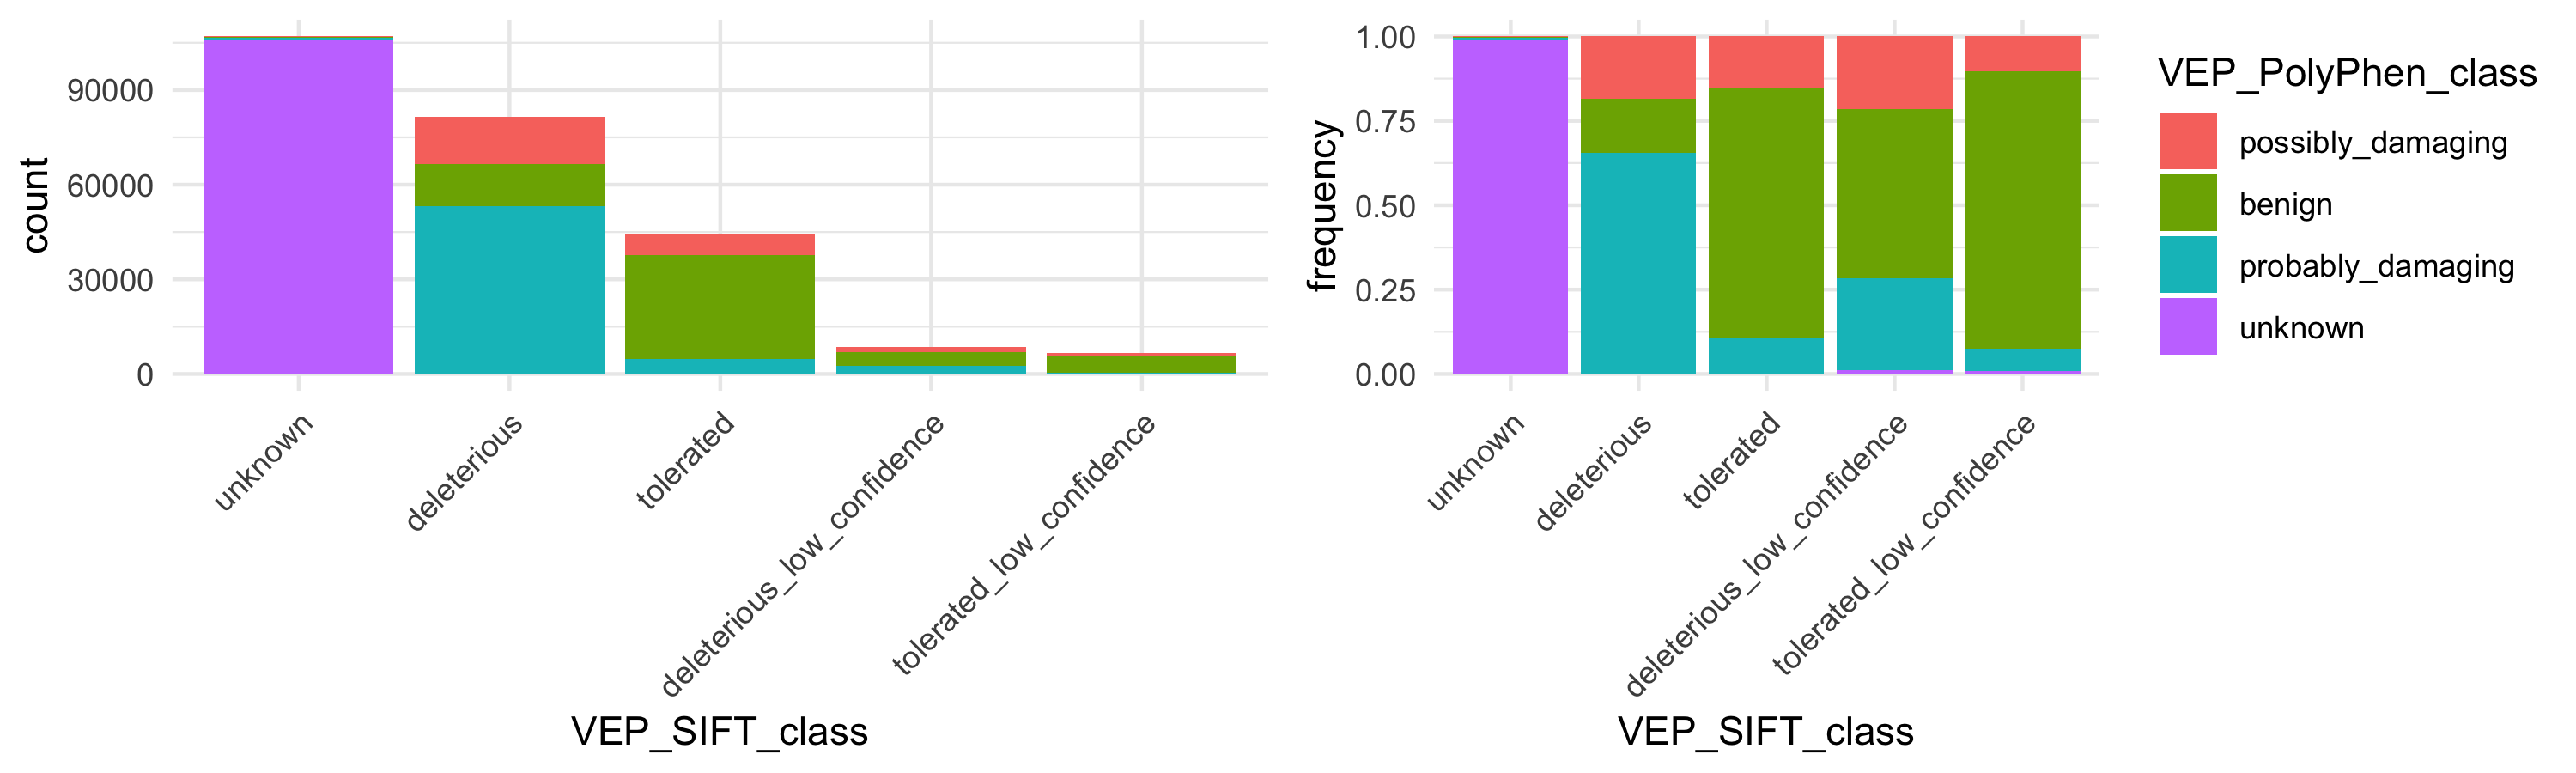

In [149]:
plot_contingency_table_as_histograms(impact, "VEP_SIFT_class", "VEP_PolyPhen_class")

In [175]:
impact_temp <- impact[impact$VEP_SIFT_class != "unknown" & impact$VEP_PolyPhen_class != "unknown",]

Warning sqrt y scale.

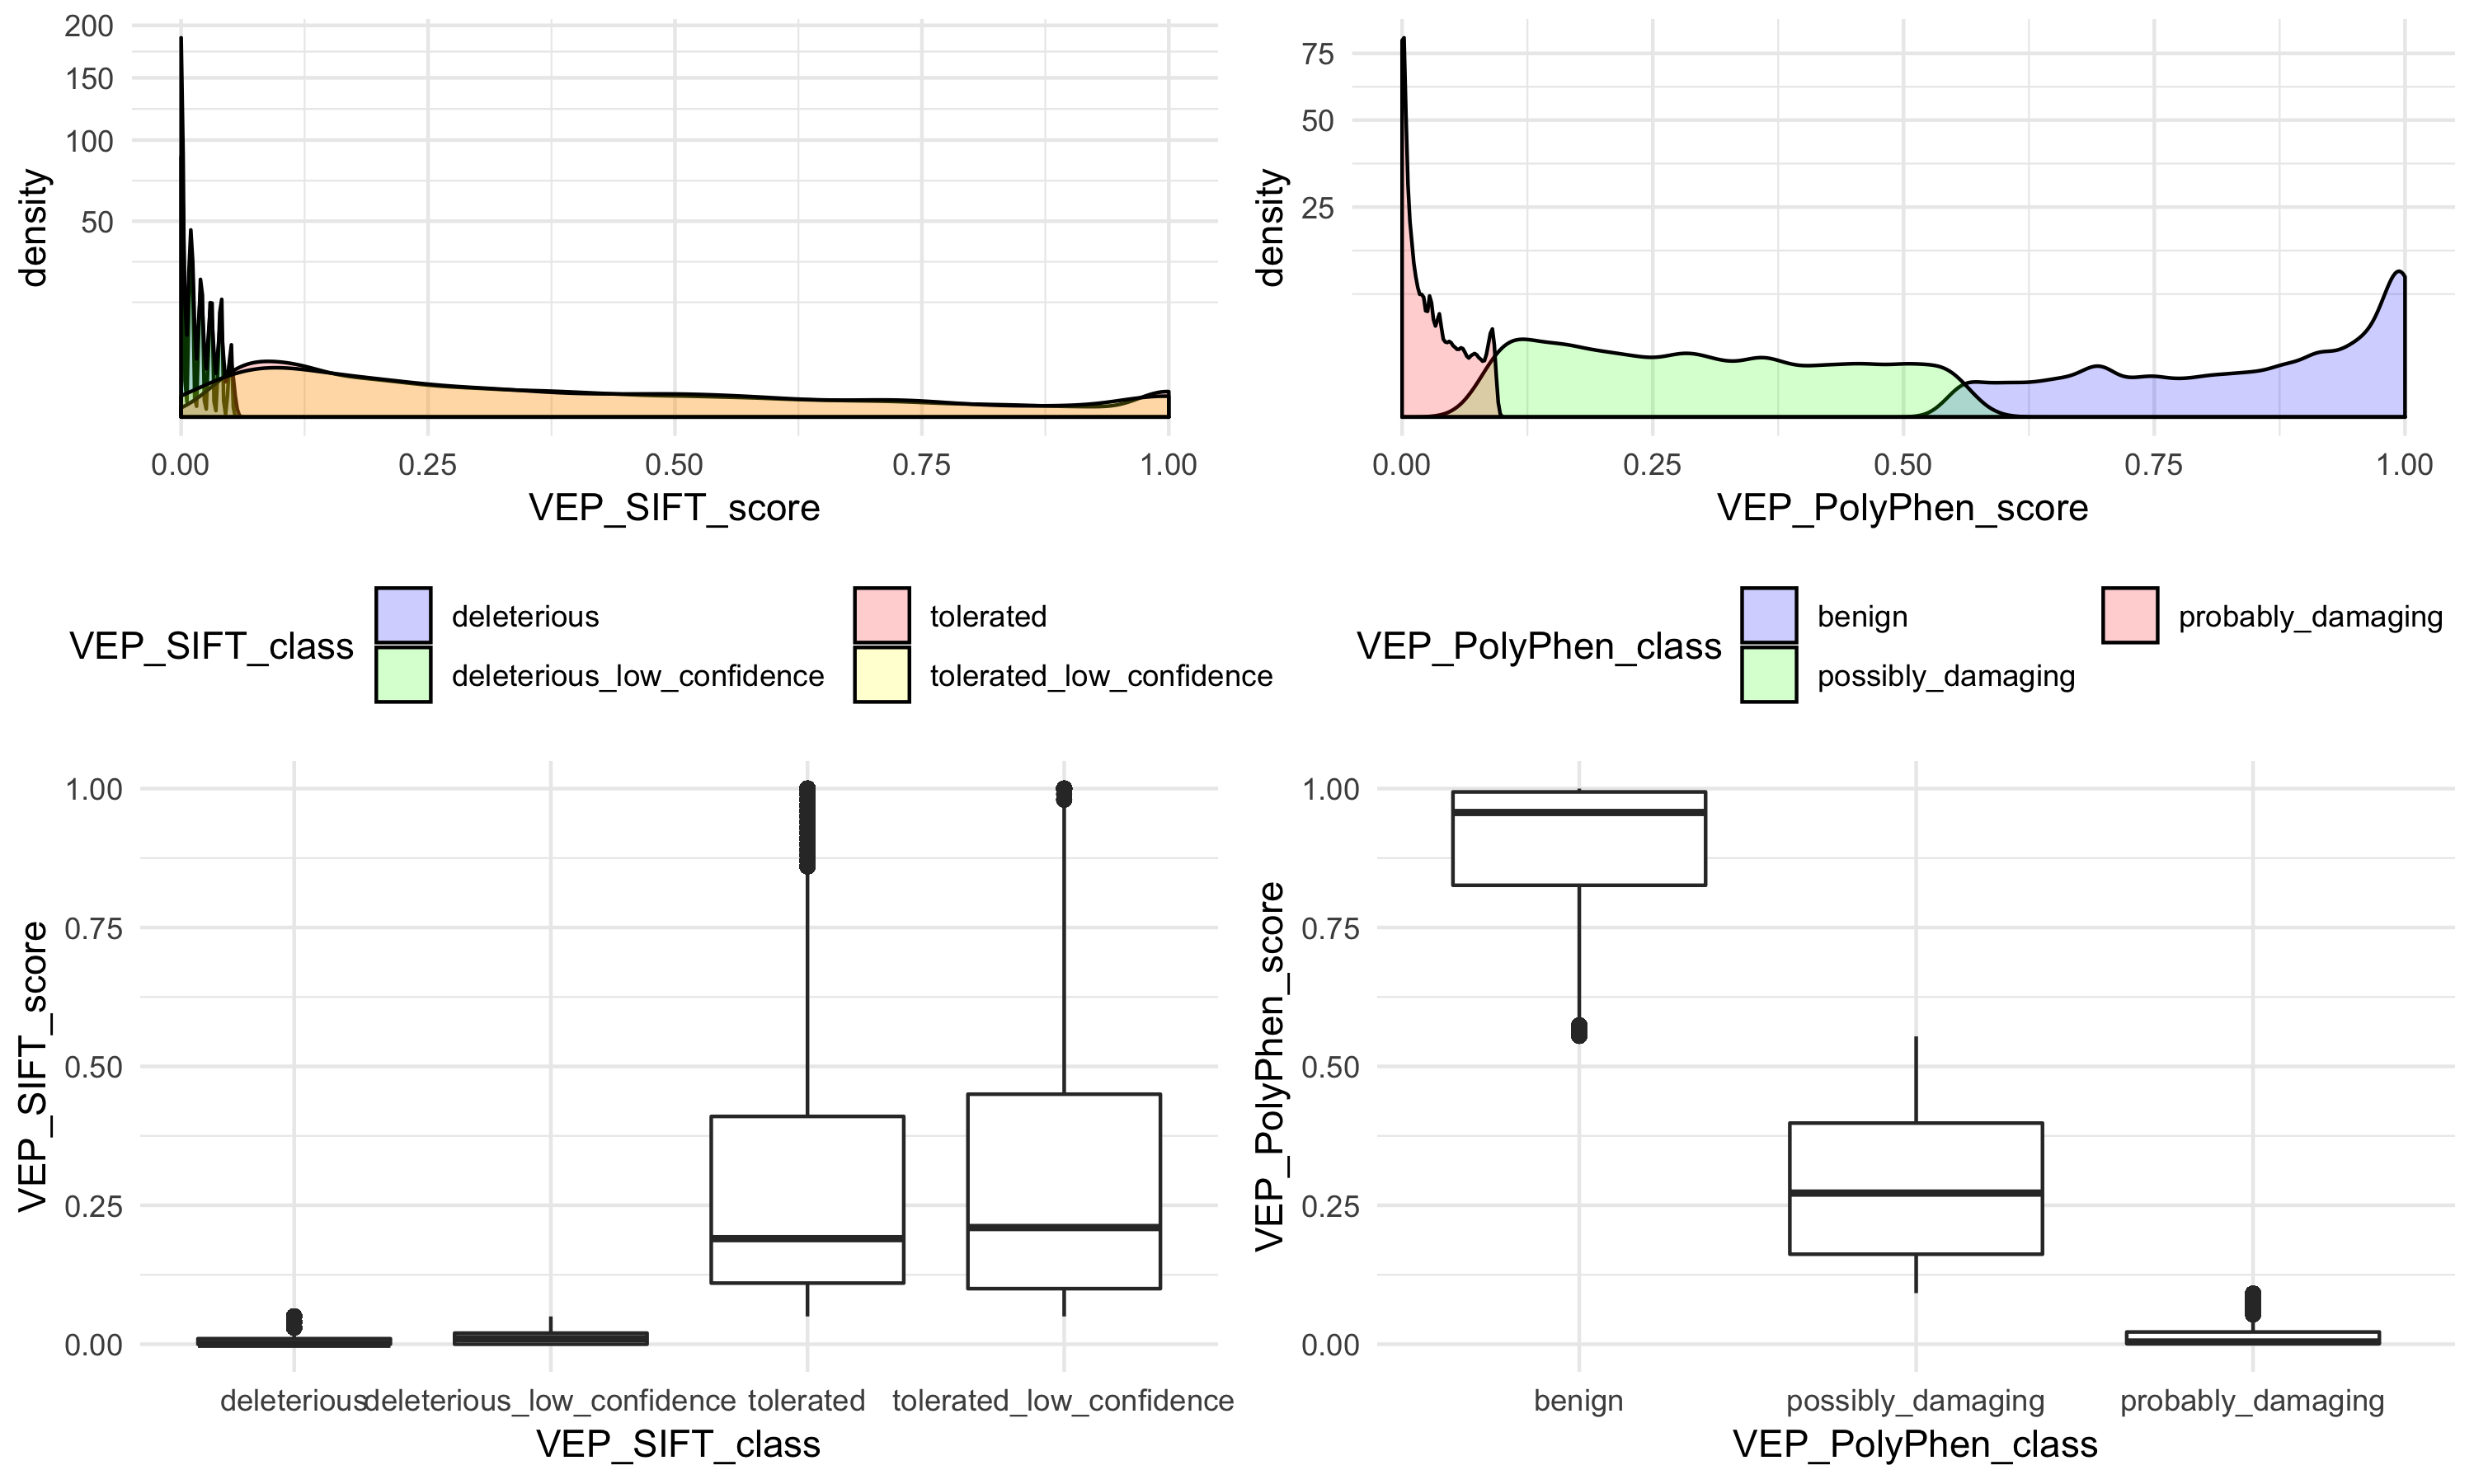

In [190]:
plot1 <- plot_density(impact_temp, "VEP_SIFT_score", fill = "VEP_SIFT_class") + theme(legend.position="bottom") + guides(fill = guide_legend(ncol = 2)) + scale_y_sqrt()
plot2 <- plot_density(impact_temp, "VEP_PolyPhen_score", fill = "VEP_PolyPhen_class") + theme(legend.position="bottom") + guides(fill = guide_legend(ncol = 2)) + scale_y_sqrt()
plot3 <- ggplot(impact_temp) + geom_boxplot(aes(VEP_SIFT_class, VEP_SIFT_score))
plot4 <- ggplot(impact_temp) + geom_boxplot(aes(VEP_PolyPhen_class, VEP_PolyPhen_score))
notebook_plot_size(10, 6)
grid.arrange(plot1, plot2, plot3, plot4, ncol = 2)

In [161]:
impact$VEP_PolyPhen_score <- 1 - impact$VEP_PolyPhen_score

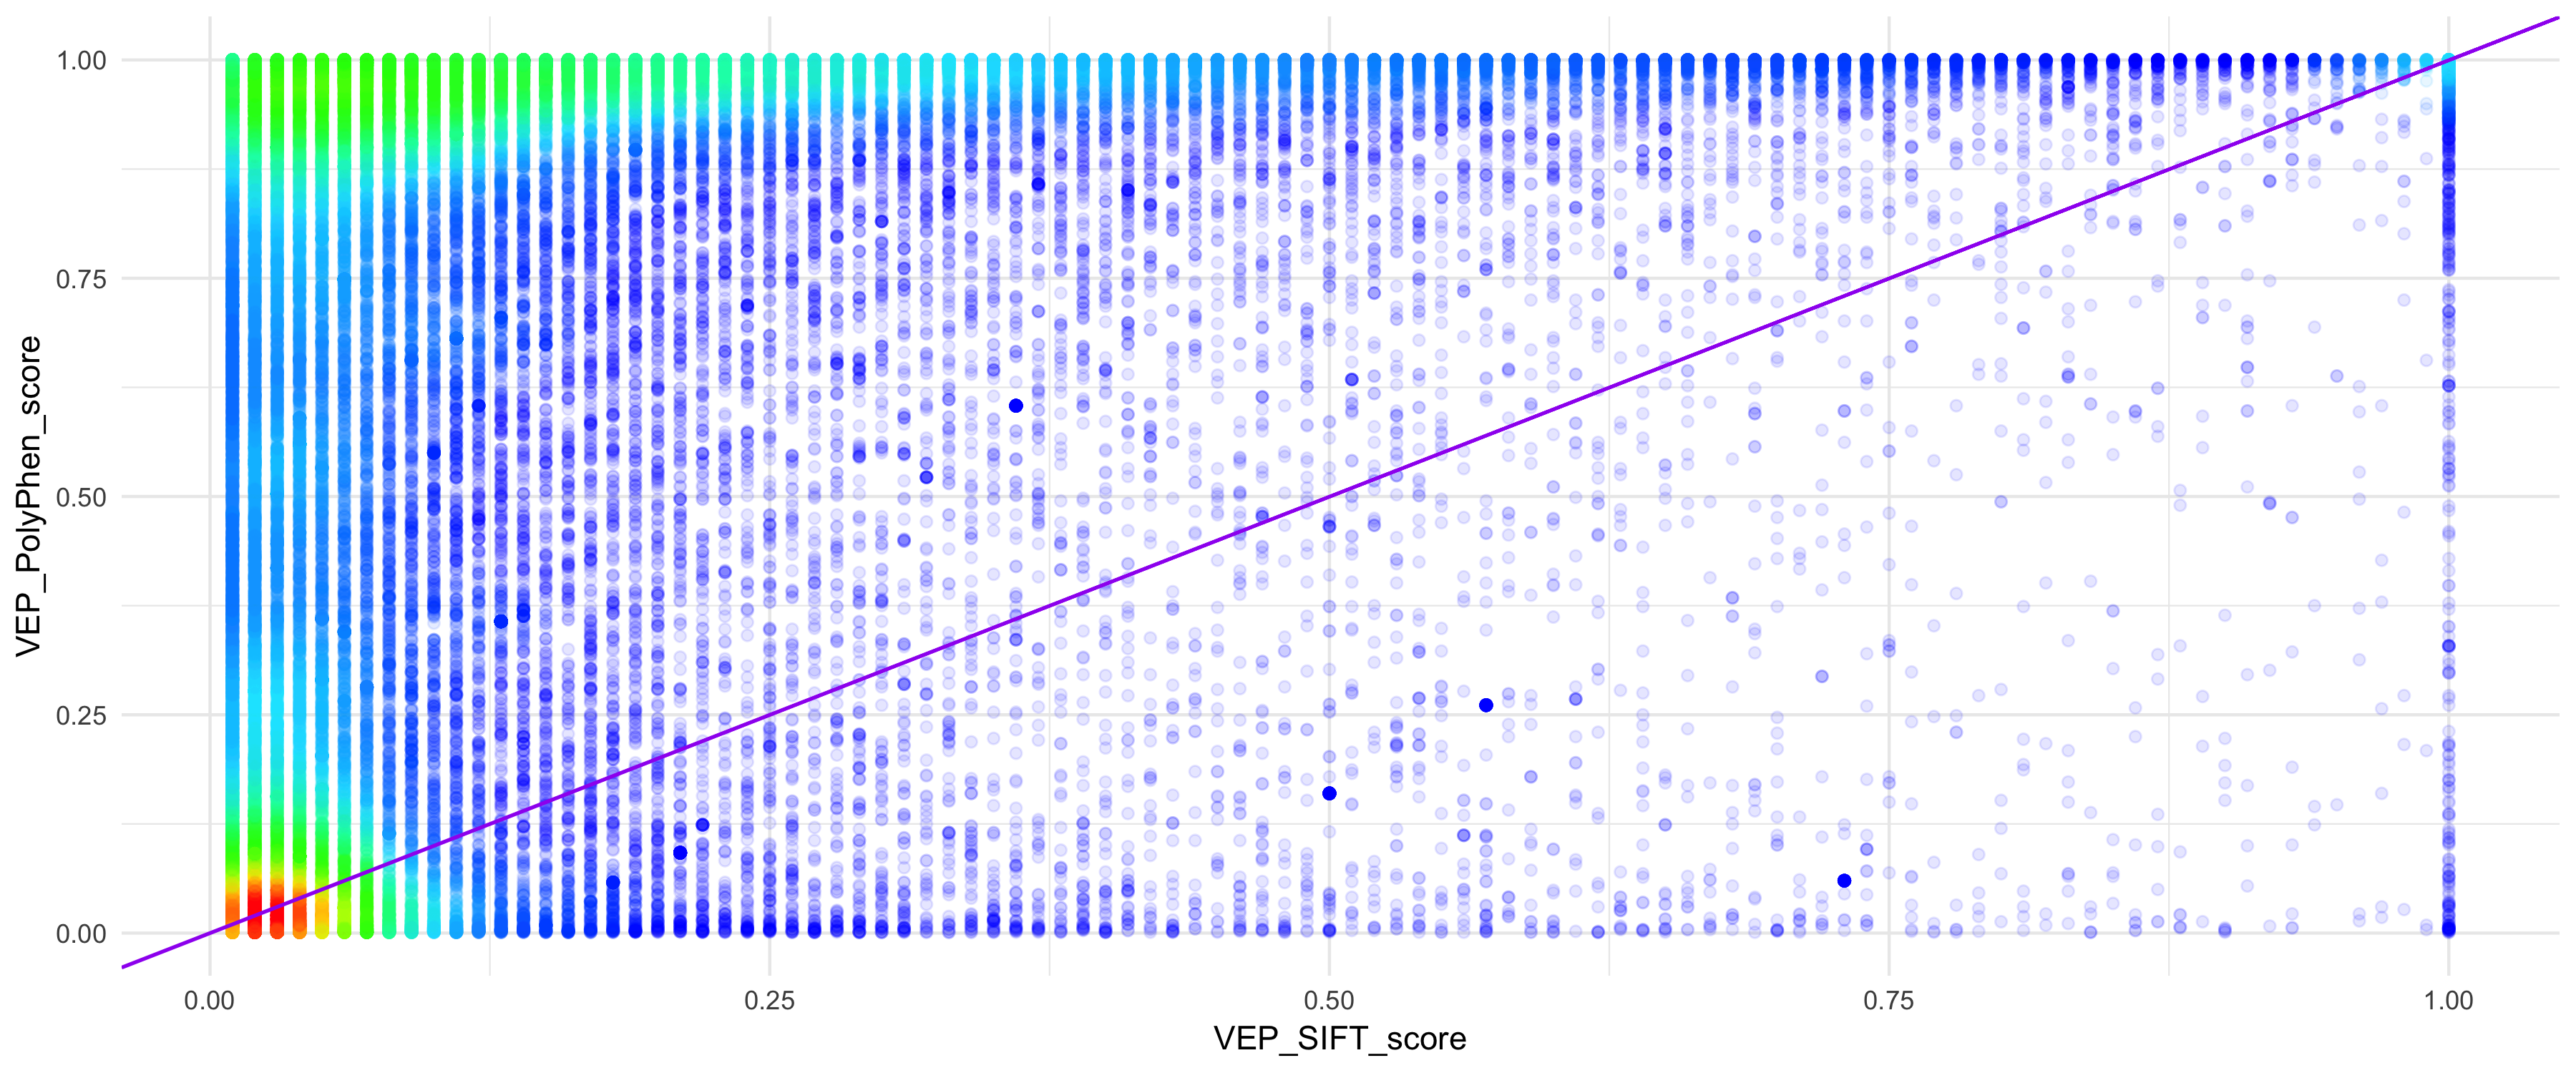

In [192]:
plot_density_2d(impact_temp[impact_temp$VEP_SIFT_score != 0 & impact_temp$VEP_PolyPhen_score != 0,],
                "VEP_SIFT_score", "VEP_PolyPhen_score", points_only = TRUE, height = 5) + geom_abline(intercept = 0, slope = 1, color = "purple", size = 0.6)

### VEP gnomAD annotations

In [205]:
vep_gnomad_colnames

[1] "VEP_gnomAD_AF"   "VEP_MAX_AF"      "VEP_MAX_AF_POPS"

#### `VEP_gnomAD_AF` vs `Kaviar_AF`

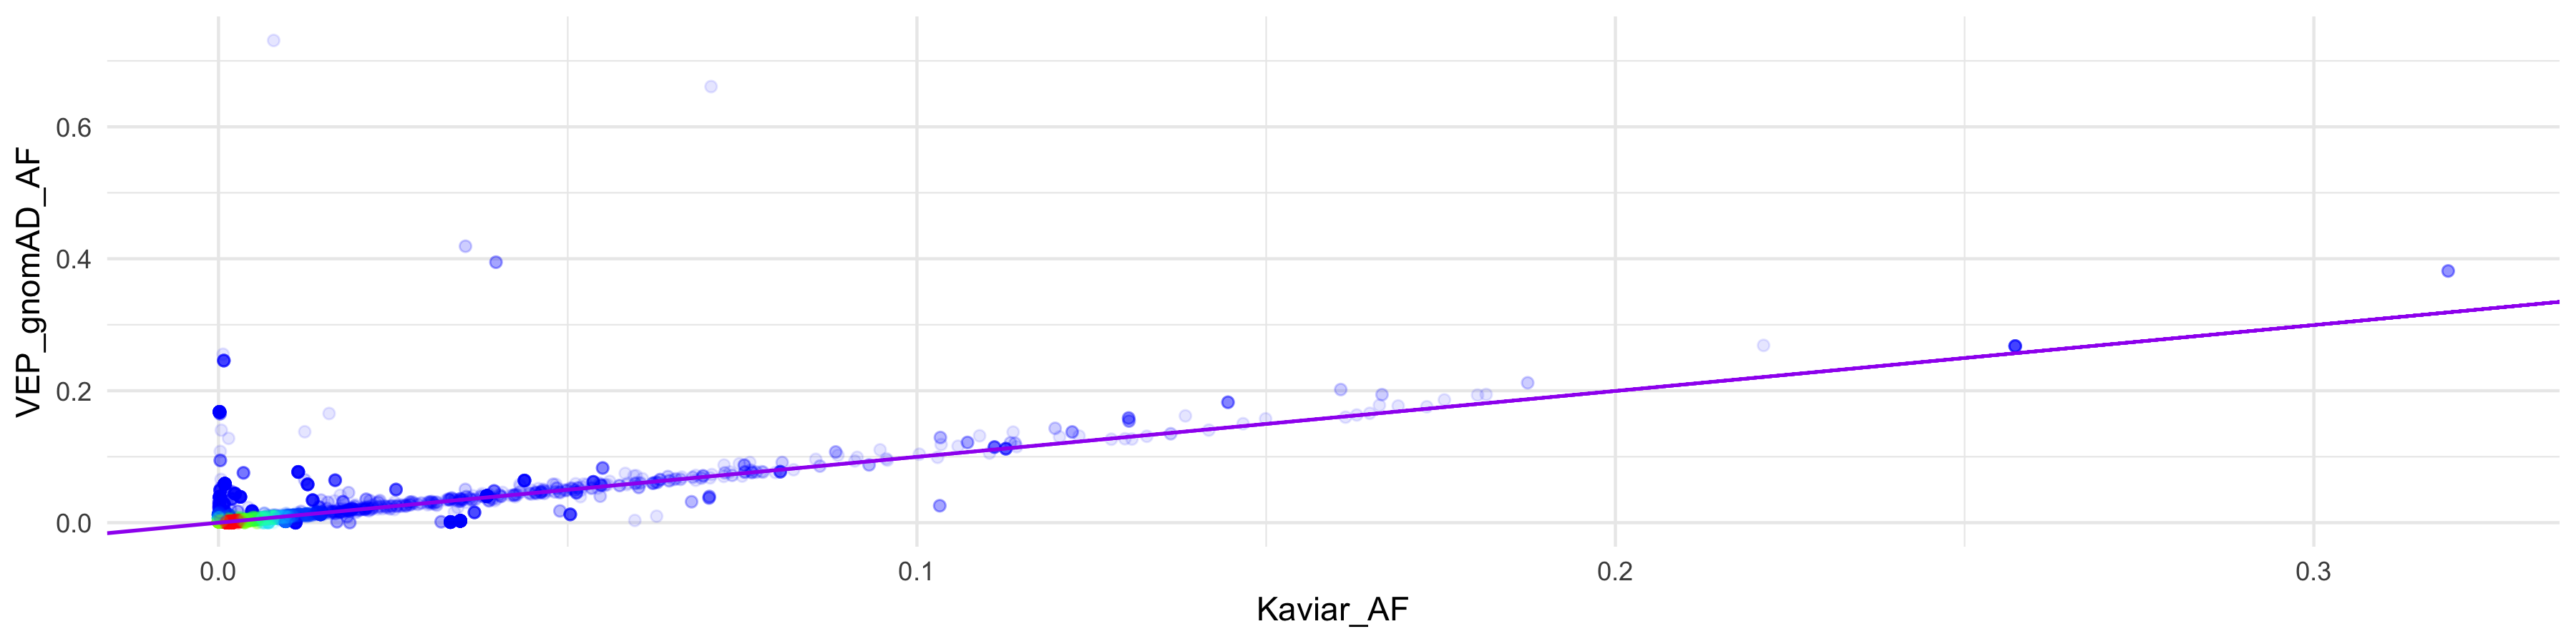

In [217]:
plot_density_2d(impact[impact$Kaviar_AF > 0.001 | impact$VEP_gnomAD_AF > 0.001,], "Kaviar_AF", "VEP_gnomAD_AF", points_only = TRUE, height = 3) + geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6)

In [212]:
nrow(impact[abs(impact$Kaviar_AF - impact$VEP_gnomAD_AF) >= 0.1,])
get_table(impact$Hugo_Symbol[abs(impact$Kaviar_AF - impact$VEP_gnomAD_AF) >= 0.1])

[1] 72

values      count freq 
1 LATS2       40    55.6%
2 HLA-B       13    18.1%
3 NCOR1       12    16.7%
4 HLA-A        4    5.6% 
5 KMT2C        2    2.8% 
6 TET1         1    1.4% 
7 -- total -- 72    100%

#### `VEP_MAX_AF` and `VEP_MAX_AF_POPS`

Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”

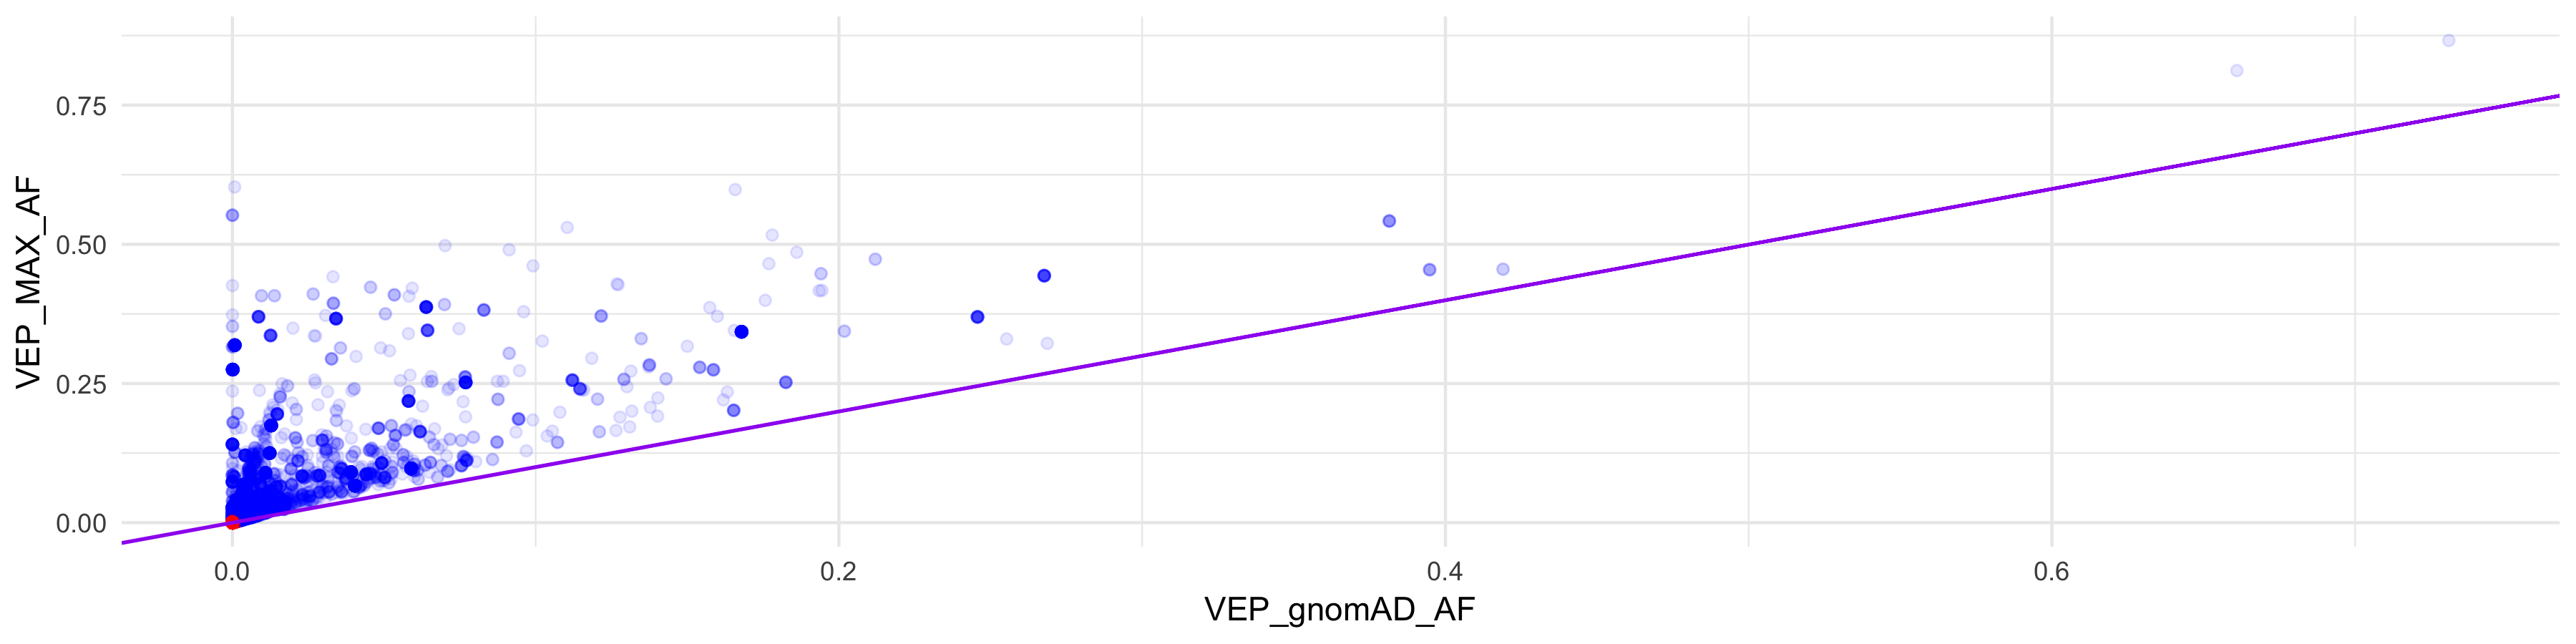

In [219]:
plot_density_2d(impact, "VEP_gnomAD_AF", "VEP_MAX_AF", points_only = TRUE, height = 3) + geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6)

### VEP COSMIC annotations

In [225]:
vep_cosmic_colnames

[1] "VEP_COSMIC"     "VEP_COSMIC_CDS" "VEP_COSMIC_AA"  "VEP_COSMIC_CNT"

In [231]:
head(unique(impact[, c("VEP_COSMIC", "VEP_COSMIC_CDS", "VEP_COSMIC_AA", "VEP_COSMIC_CNT")]), 100)

VEP_COSMIC                                                                                                                        
1   COSM45830                                                                                                                         
2   unknown                                                                                                                           
15  COSM3782301&COSM3782299&COSM3782300&COSM3782296&COSM3782297&COSM3782298                                                           
19  COSM5570655&COSM5570656&COSM5570654                                                                                               
25  COSM3693022&COSM4784258                                                                                                           
33  COSM46345                                                                                                                         
42  COSM5666                                                                                                                          
43  COSM5219                                                                                                                          
44  COSM1651089&COSM403987&COSM4389714                                                                                                
48  COSM99602&COSM99020&COSM1640830&COSM99021&COSM3356964&COSM10662                                                                   
50  COSM255876&COSM766                                                                                                                
55  COSM1413357                                                                                                                       
56  COSM3846363                                                                                                                       
60  COSM5627702                                                                                                                       
61  COSM5089                                                                                                                          
63  COSM4422921                                                                                                                       
66  COSM392318&COSM392319&COSM392316&COSM2744751&COSM4336260&COSM392317&COSM13120&COSM6482&COSM242001&COSM242002&COSM242003&COSM242004
68  COSM266187                                                                                                                        
71  COSM291026                                                                                                                        
83  COSM131478&COSM131479&COSM10817&COSM3717634&COSM1646861                                                                           
88  COSM1252034&COSM1252033                                                                                                           
101 COSM1614454                                                                                                                       
103 COSM289612&COSM1649348&COSM11354&COSM3522688                                                                                      
121 COSM1645335&COSM99729&COSM10660&COSM3356963                                                                                       
124 COSM271871&COSM27502                                                                                                              
127 COSM4767585&COSM4767586                                                                                                           
128 COSM4772240                                                                                                                       
129 COSM17461&COSM1742346                                                                                                             
133 COSM763&COSM125370                                                                   

#### `VEP_COSMIC_CNT` vs `cosmic_count`

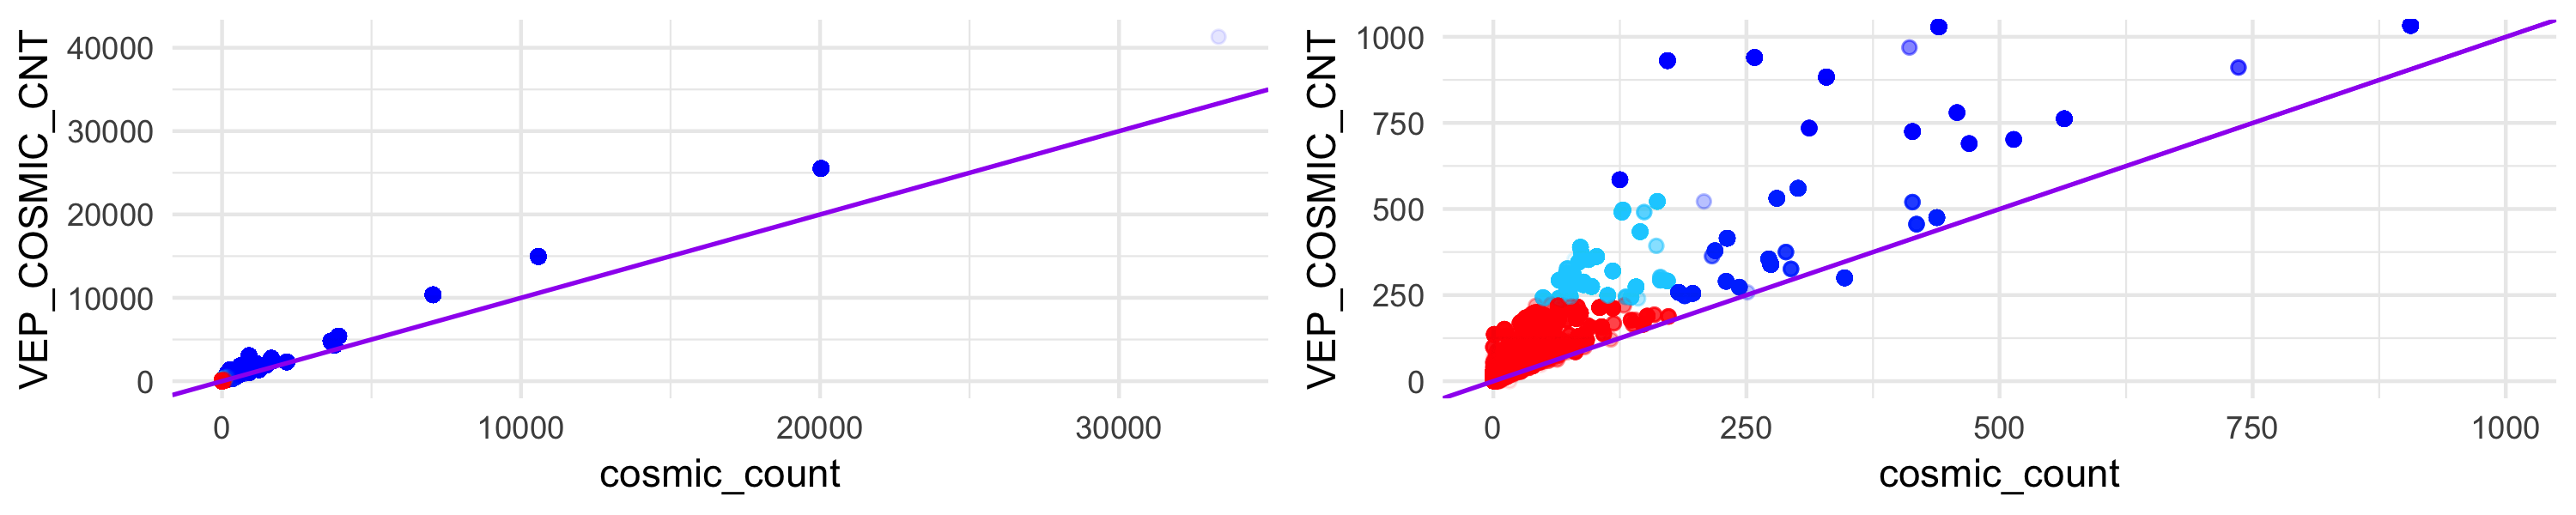

In [88]:
plot1 <- plot_density_2d(impact[impact$cosmic_count > 0 | impact$VEP_COSMIC_CNT > 0,],
                "cosmic_count", "VEP_COSMIC_CNT", points_only = TRUE) + 
    geom_abline(intercept = 0, slope = 1, color ="purple", size = 0.6)
plot2 <- plot1 + coord_cartesian(xlim = c(0:1000), ylim = c(0:1000))

plot_side_by_side(plot1, plot2)

[1] 1943

[1] "Number of different genes:  174"


[1] 4

[1] "Number of different genes:  3"


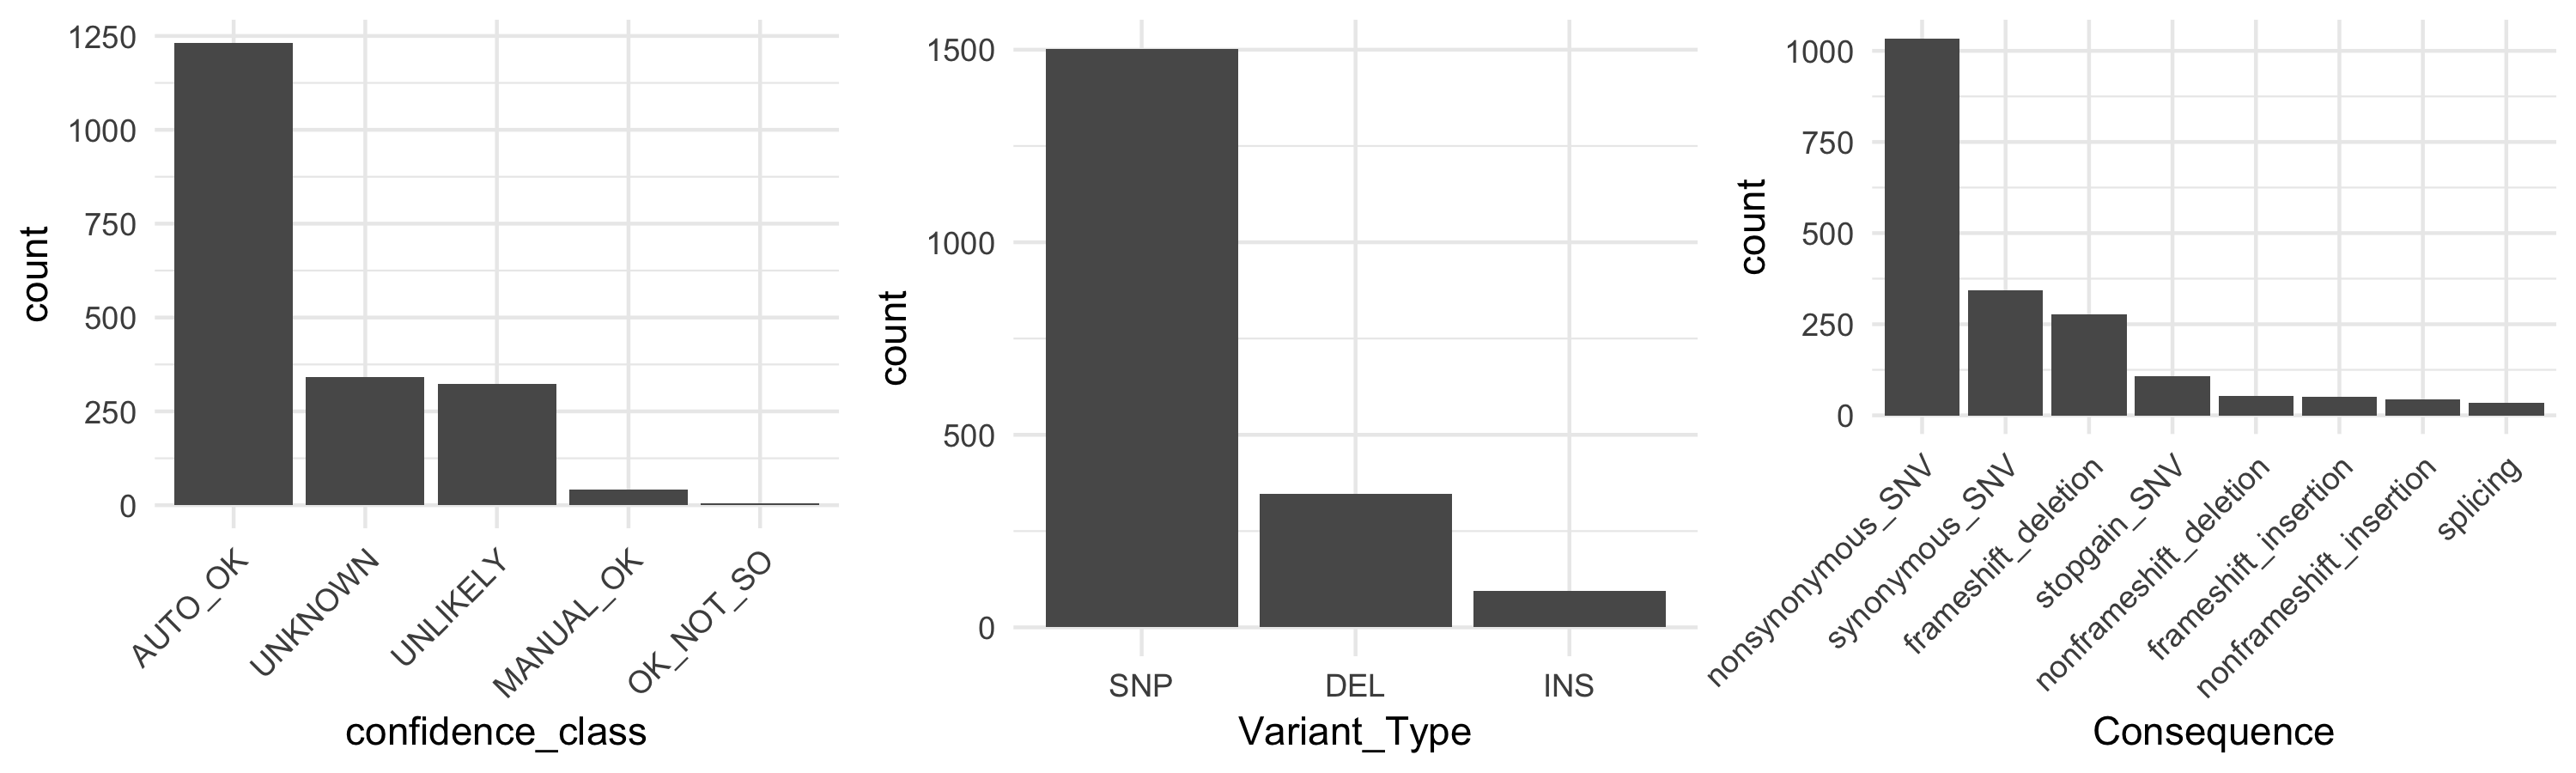

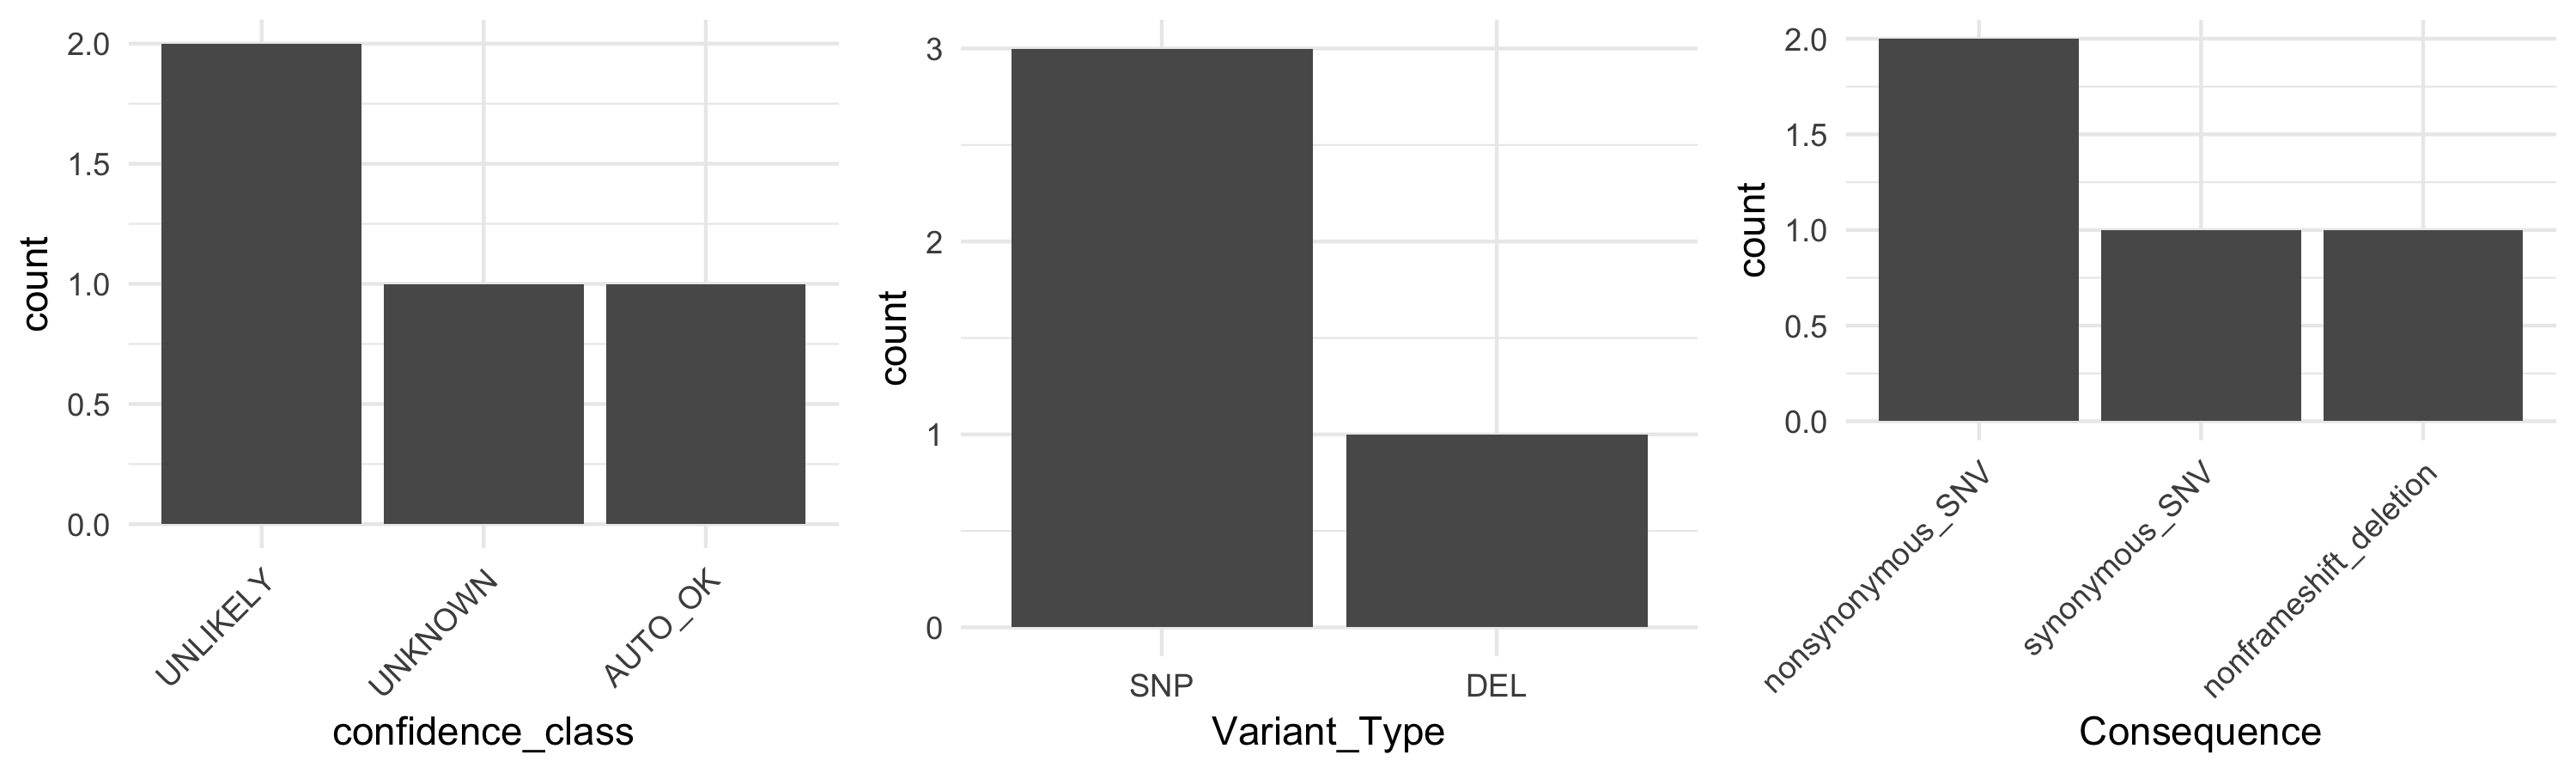

In [89]:
nrow(impact[impact$cosmic_count == 0 & impact$VEP_COSMIC_CNT > 5,])
get_possible_correlations(impact[impact$cosmic_count == 0 & impact$VEP_COSMIC_CNT > 5,])

nrow(impact[impact$cosmic_count > 5  & impact$VEP_COSMIC_CNT == 0,])
get_possible_correlations(impact[impact$cosmic_count > 5  & impact$VEP_COSMIC_CNT == 0,])